# Dataset Loading and table descriptions

In [1]:
from epo.tipdata.epab import EPABClient
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
epab = EPABClient('PROD')

In [3]:
epab.fields()

WidDatabaseFields(header='', input_data={'': [{'name': 'epab_doc_id', 'type': 'STRING', 'mode': 'REQUIRED', 'd…

# Patent data extraction

In the following code I extract the data that I think I need from the database. I arrived to what is neeed through analisys and consultation with experts in the field. I avoided the text data since it requires NLP texhniques to be incorporated into the dataset, although it is a convenient clustering example. 

## Basic patent data 

In [4]:
def get_sql_basic_data_querry(pub_type):
    # I am using the following code to query the EPO full text database: #Here we select all of the A1 publications

# Defining the fields to select
    selection = (
        "a.application,"
        "a.search_report,"
        "a.publication,"
        "a.representative,"
        "a.inventor AS inventor,"
        "a.applicant AS applicant,"
        "MIN(b.publication.date) AS patent_granted_date,"    
        "CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted"
    )
    if pub_type in ['A1','A3']:
        condition = (
        f" WHERE a.publication.kind LIKE '{pub_type}'"
        f" AND a.search_report IS NOT NULL"
        )
    else:
        condition = (
        f" WHERE a.publication.kind LIKE '{pub_type}'"
        f" AND EXISTS ("
        f"   SELECT 1 FROM `{epab.full_table_name}` AS c "
        f"   WHERE c.application.number = a.application.number "
        f"   AND c.publication.kind LIKE 'A3%'"
        f"   AND c.search_report IS NOT NULL"
        f" )"
    )

    # Putting the statement together
    statement = (
        f"SELECT {selection} "
        f"FROM `{epab.full_table_name}` AS a "
        f"LEFT JOIN `{epab.full_table_name}` AS b "
        f"ON a.application.number = b.application.number "
        f"AND b.publication.kind LIKE 'B1%' "
        f"{condition} "
        # Group by your dimension fields (not by the new aggregates)
        f"GROUP BY "
        f"a.search_report,"
        f"a.application,"
        f"a.publication,"
        f"a.inventor,"
        f"a.applicant,"
        f"a.representative;"
    )

    return statement
# Querying EPAB with the SQL statement

In [6]:
A3_docs = epab.sql_query(get_sql_basic_data_querry('A3'))

In [7]:
A1_docs = epab.sql_query(get_sql_basic_data_querry('A1'))

In [10]:
import pandas as pd

def extract_record(record):
    # Extract from 'application'
    application = record.get('application', {})
    application_number = application.get('number')
    filing_date = application.get('filing_date')
    
    # Extract from 'search_report' (if it exists)
    search_report = record.get('search_report', {})
    ipc_field = search_report.get('ipc_field')
    is_no_unity = search_report.get('is_no_unity')
    is_incomplete_search = search_report.get('is_incomplete_search')
    is_no_search = search_report.get('is_no_search')
    
    # Extract applicant names and countries (handling lists)
    applicants = record.get('applicant', [])
    applicant_names = [app.get('name') for app in applicants]
    applicant_countries = [app.get('country') for app in applicants]
    
    # Extract inventor names and countries (handling lists)
    inventors = record.get('inventor', [])
    inventor_names = [inv.get('name') for inv in inventors]
    inventor_countries = [inv.get('country') for inv in inventors]
    
    # Extract representative info; if None, use default values
    representative = record.get('representative')
    if representative is None:
        representative_name = None
        representative_country = None
    else:
        representative_name = representative.get('name')
        representative_country = representative.get('country')
    
    # Patent granted info
    patent_granted_date = record.get('patent_granted_date')
    patent_granted = record.get('patent_granted')
    
    # Extract publication type from publication (assuming "kind" represents type)
    publication = record.get('publication', {})
    publication_types = publication.get('kind')
    publication_date = publication.get('date')
    publication_num = publication.get('number')

    
    return {
        'application_number': application_number,
        'filing_date': filing_date,
        'ipc_field': ipc_field,
        'is_no_unity': is_no_unity,
        'is_incomplete_search': is_incomplete_search,
        'is_no_search': is_no_search,
        'applicant_names': applicant_names,
        'applicant_countries': applicant_countries,
        'inventor_names': inventor_names,
        'inventor_countries': inventor_countries,
        'representative_name': representative_name,
        'representative_country': representative_country,
        'patent_granted_date': patent_granted_date,
        'patent_granted': patent_granted,
        'publication_types': publication_types,
        'publication_date': publication_date,
        'publication_number': publication_num

    }

In [12]:
A3_rows = [extract_record(entry) for entry in A3_docs]

In [15]:
A1_rows = [extract_record(entry) for entry in A1_docs]

In [16]:
A1_df = pd.DataFrame(A1_rows)
A3_df = pd.DataFrame(A3_rows)

In [17]:
import pandas as pd

# Suppose df is your DataFrame and it includes a column 'publication_date'
# Convert publication_date to datetime if not already (assuming format 'YYYYMMDD'):
A3_df['publication_date'] = pd.to_datetime(A3_df['publication_date'], format='%Y%m%d', errors='coerce')

# Group by application_number and find the index of the minimum publication_date in each group
min_pub_date_idx = A3_df.groupby('application_number')['publication_date'].idxmin()

# Use these indices to filter the original DataFrame
A3_df_clean = A3_df.loc[min_pub_date_idx].reset_index(drop=True)

In [18]:
A1_df.application_number.value_counts()

application_number
21199951.1    1
12178557.0    1
16200386.7    1
14187861.1    1
15201045.0    1
             ..
21461520.5    1
16201017.7    1
16153146.2    1
17156431.3    1
20201174.8    1
Name: count, Length: 633716, dtype: int64

In [19]:
set_A3_app_nums={app_num for app_num in A3_df.application_number}
set_A1_app_nums={app_num for app_num in A1_df.application_number}

In [20]:
doubly_published_search_reports = set_A1_app_nums.intersection(set_A3_app_nums)

In [21]:
len(doubly_published_search_reports)

181

For the doubly published search reports we want to keep the ones that are chronologically before the others, so we will group the fina dataframe and drop the later ones.

In [22]:
basic_data_combined_df = pd.concat([A3_df_clean, A1_df], ignore_index=True)

In [23]:
basic_data_combined_df['publication_date'] = pd.to_datetime(basic_data_combined_df['publication_date'], format='%Y%m%d', errors='coerce')

# Group by application_number and find the index of the minimum publication_date in each group
min_pub_date_idx = basic_data_combined_df.groupby('application_number')['publication_date'].idxmin()

# Use these indices to filter the original DataFrame
basic_data_combined_df_clean = basic_data_combined_df.loc[min_pub_date_idx].reset_index(drop=True)

In [24]:
basic_data_combined_df_clean.to_csv('./Data/basic_data_all_search_reports.csv',sep='\t',index=False)

## Adding srep and reference data

In [1]:
def get_sql_refs_srep_data_querry(pub_type):
    # I am using the following code to query the EPO full text database: #Here we select all of the A1 publications

# Defining the fields to select
    selection = (
        "a.application,"
        "MIN(a.publication.date) AS publication_date,"
        "a.srep_citation,"
        "a.reference,"
        "MIN(b.publication.date) AS patent_granted_date,"    
        "CASE WHEN MIN(b.publication.date) IS NOT NULL THEN TRUE ELSE FALSE END AS patent_granted"
    )
    if pub_type in ['A1','A3']:
        condition = (
        f" WHERE a.publication.kind LIKE '{pub_type}'"
        f" AND a.search_report IS NOT NULL"
        )
    else:
        condition = (
        f" WHERE a.publication.kind LIKE '{pub_type}'"
        f" AND EXISTS ("
        f"   SELECT 1 FROM `{epab.full_table_name}` AS c "
        f"   WHERE c.application.number = a.application.number "
        f"   AND c.publication.kind LIKE 'A3%'"
        f"   AND c.search_report IS NOT NULL"
    
        f" )"
    )

    # Putting the statement together
    statement = (
        f"SELECT {selection} "
        f"FROM `{epab.full_table_name}` AS a "
        f"LEFT JOIN `{epab.full_table_name}` AS b "
        f"ON a.application.number = b.application.number "
        f"AND b.publication.kind LIKE 'B1%' "
        f"{condition} "
        # Group by your dimension fields (not by the new aggregates)
        f"GROUP BY "
        f"a.srep_citation,"
        f"a.reference,"
        f"a.application;"
    )

    return statement
# Querying EPAB with the SQL statement

In [ ]:
A1_pubs_srep_refs = epab.sql_query(get_sql_refs_srep_data_querry('A1'))
A2_pubs_srep_refs = epab.sql_query(get_sql_refs_srep_data_querry('A2'))
A3_pubs_srep_refs = epab.sql_query(get_sql_refs_srep_data_querry('A3'))

In [2]:

import pandas as pd

def map_to_df_refs(data):
    # Assume 'data' is your list of patent entry dictionaries.
    # data = [ { ... }, { ... }, ... ]
    
    summaries = []
    
    for entry in data:
        summary = {}
        
        # 1. Application number
        summary["application_number"] = entry.get("application", {}).get("number", None)
        # 2. date
        summary['date'] = entry.get('publication_date',None)

        
        # Derived from Srep Citation:
        srep_tuples = []
        srep_is_patent_flags = []
        
        for citation in entry.get("srep_citation", []):
            # Extract the relevant_claims value
            claims_range = citation.get("relevant_claims", "")
            # Process the category: remove spaces and commas; only keep allowed letters.
            category_str = citation.get("category", "")
            allowed_categories = {"X", "Y", "P", "A", "D"}
            # Build a string containing only characters in allowed_categories
            filtered_categories = "".join([char for char in category_str if char in allowed_categories])
            
            # Append tuple (relevant_claims, filtered_categories)
            srep_tuples.append((claims_range, filtered_categories))
        
            # Append the is_patent flag (1 if True, 0 if False)
            srep_is_patent_flags.append(1 if citation.get("is_patent") else 0)
        
        summary["srep_tuples"] = srep_tuples
        summary["srep_is_patent_flags"] = srep_is_patent_flags
        
        # Derived from Reference:
        references = entry.get("reference", [])
        summary["num_references"] = len(references)
        
        ref_found_flags = []
        ref_is_patent_flags = []
        
        # Collect all srep citation documents for substring checking.
        srep_docs = [citation.get("document", "") for citation in entry.get("srep_citation", [])]
        
        for ref in references:
            ref_doc = ref.get("document", "")
            # Check if the reference document is a substring of any srep citation's document.
            found = any(ref_doc in srep_doc for srep_doc in srep_docs)
            ref_found_flags.append(1 if found else 0)
            
            # Append is_patent flag for the reference.
            ref_is_patent_flags.append(1 if ref.get("is_patent") else 0)
        
        summary["reference_found_flags"] = ref_found_flags
        summary["reference_is_patent_flags"] = ref_is_patent_flags
        
        summaries.append(summary)

    df = pd.DataFrame(summaries)
    # Sort the dataframe by date so the minimal date comes first for each application_number
    df= df.sort_values(by='date')

    # Drop duplicates, keeping only the first occurrence for each application_number
    df = df.drop_duplicates(subset='application_number', keep='first')
    df.reset_index(inplace=True,drop=True)
    df.drop(columns = ['date'],inplace=True)
    return df

In [ ]:
df_A1_refs_srep = map_to_df_refs(A1_pubs_srep_refs)
df_A2_refs_srep = map_to_df_refs(A2_pubs_srep_refs)
df_A3_refs_srep = map_to_df_refs(A3_pubs_srep_refs)

In [ ]:
# Create a copy of df_A3 to work on
df_A3_updated = df_A3_refs_srep.copy()

# Set 'application_number' as the index for both dataframes
df_A3_updated.set_index('application_number', inplace=True)
df_A2_indexed = df_A2.set_index('application_number')

# Specify the columns to replace
cols_to_update = ['num_references', 'reference_found_flags', 'reference_is_patent_flags']

# Use update to overwrite the values in df_A3 with those from df_A2, for matching application_numbers
df_A3_updated.update(df_A2_indexed[cols_to_update])

# Reset index to get back 'application_number' as a column
df_A3_refs_srep = df_A3_updated.reset_index()


In [ ]:
df_A3_refs_srep.to_csv('Data/A3_srep_ref_compressed.csv',sep='\t',index=False)
df_A1_refs_srep.to_csv('Data/A1_srep_ref_compressed.csv',sep='\t',index=False)

In [3]:
combined_refs_srep = df = pd.concat([df_A3_refs_srep, df_A1_refs_srep], ignore_index=True)

In [5]:
combined_refs_srep.to_csv('./Data/srep_ref_compressed_all_pubs.csv',sep='\t',index=False)

## Adding claims trees

In [3]:
def get_claims_sql_querry(pub_type):
    # Defining the fields to select
    selection = (
        "a.application,"
        "MIN(a.publication.date) AS publication_date,"
        "a.claims")
    if pub_type in ['A1','A3']:
        condition = (
        f" WHERE a.publication.kind LIKE '{pub_type}%'"
        f" AND a.search_report IS NOT NULL"
        )
    else:
        condition = (
        f" WHERE a.publication.kind LIKE '{pub_type}%'"
        f" AND EXISTS ("
        f"   SELECT 1 FROM `{epab.full_table_name}` AS c "
        f"   WHERE c.application.number = a.application.number "
        f"   AND c.publication.kind LIKE 'A3%'"
        f"   AND c.search_report IS NOT NULL"
    
        f" )"
    )

    # Putting the statement together
    statement = (
        f"SELECT {selection} "
        f"FROM `{epab.full_table_name}` AS a "
        f"LEFT JOIN `{epab.full_table_name}` AS b "
        f"ON a.application.number = b.application.number "
        f"AND b.publication.kind LIKE 'B1%' "
        f"{condition} "
        # Group by your dimension fields (not by the new aggregates)
        f"GROUP BY "
        f"a.claims,"
        f"a.application;"
    )

    return statement
    

In [4]:
import re
import xml.etree.ElementTree as ET
from anytree import Node, RenderTree

def generate_claim_trees(claims_container):
    """
    Generate a list of anytree trees from a claims container.
    
    The function selects the claims based on the priority:
      EN > DE > FR.
    It parses the XML in the 'text' field and uses a language-specific, case‑insensitive regex
    to first find numeric dependency references (linking claims explicitly by number).
    
    Then, in a second pass for all languages, it checks for phrases that indicate non‑numeric
    dependencies. The linking rule now is:
      - If a claim’s text contains a plural preceding reference (e.g. in English “preceding claims”,
        in German a phrase matching our plural pattern, in French “les revendications précédentes”),
        the claim is attached as a child of the last mentioned root claim (a claim with no parent
        among those with lower claim numbers).
      - If a claim’s text contains a singular preceding reference (e.g. “preceding claim”, 
        in German a phrase matching our singular pattern, in French “la revendication précédente”),
        the claim is attached to the very last mentioned claim (regardless of parent status).
    
    Args:
      claims_container (dict): A dictionary with a key 'claims' containing a list of claim dictionaries.
                               Each dictionary should have:
                                 - 'language': language code (e.g., 'EN', 'DE', 'FR')
                                 - 'text': a string with the XML of the claims.
    
    Returns:
      list: A list of anytree root nodes representing the claim trees.
    """
    # --- Select claims group by language priority ---
    priority = ['EN', 'DE', 'FR']
    selected_claim_group = None
    for lang in priority:
        for claim_group in claims_container.get('claims', []):
            if claim_group.get('language', '').upper() == lang:
                selected_claim_group = claim_group
                break
        if selected_claim_group:
            break

    if not selected_claim_group:
        if claims_container.get('claims'):
            selected_claim_group = claims_container['claims'][0]
        else:
            return []  # No claims available.

    language = selected_claim_group.get('language', '').upper()

    # --- Numeric dependency regexes ---
    numeric_regex_by_language = {
        'EN': re.compile(r'claim(?:s)?\s+(\d+)', re.IGNORECASE),
        'DE': re.compile(r'anspr(?:u|ü)ch(?:e|en|er)?\s+(\d+)', re.IGNORECASE | re.UNICODE),
        'FR': re.compile(r'r[eé]vendic(?:ation|ations)\s+(\d+)', re.IGNORECASE)
    }
    dependency_pattern = numeric_regex_by_language.get(language, re.compile(r'claim(?:s)?\s+(\d+)', re.IGNORECASE))

    # --- Preceding reference regexes for the second pass ---
    singular_patterns_by_language = {
        # English: "preceding claim" (singular)
        'EN': re.compile(r"(?:the\s+)?preceding\s+claim\b(?!s)", re.IGNORECASE),
        # German singular: match core phrase "vorhergehend(er|e|es)" followed by "Anspruch"
        'DE': re.compile(
            r"vor(?:angegangen|hergehend)(?:en|er|e|es)?\s+anspr(?:u|ü)ch\b(?!(?:en))",
            re.IGNORECASE | re.UNICODE
        ),
        # French singular: match "la revendication précédente" (or similar)
        'FR': re.compile(r"(?:l[’']?une quelconque|une|la)\s+revendic(?:ation|ations)\s+pr[ée]c[ée]dent(?:e)?\b", re.IGNORECASE)
    }
    plural_patterns_by_language = {
        # English: "preceding claims" (plural)
        'EN': re.compile(r"(?:the\s+)?preceding\s+claims\b", re.IGNORECASE),
        # German plural: match core phrase "vorhergehend(en)" followed by "Ansprüche"
        'DE': re.compile(
            r"vor(?:angegangen|hergehend)(?:en|er|e|es)?\s+anspr(?:u|ü)ch(?:e|en)\b",
            re.IGNORECASE | re.UNICODE
        ),
        # French plural: match "les revendications précédentes" (or similar)
        'FR': re.compile(r"(?:des|les)\s+revendic(?:ation|ations)\s+pr[ée]c[ée]dent(?:es)\b", re.IGNORECASE)
    }
    singular_pattern = singular_patterns_by_language.get(language)
    plural_pattern = plural_patterns_by_language.get(language)

    # --- Parse the XML claims ---
    xml_text = selected_claim_group.get('text', '')
    xml_data = f"<root>{xml_text}</root>"
    root_xml = ET.fromstring(xml_data)

    # Build a mapping from claim number (integer) to a dictionary for each claim.
    claims = {}
    for claim in root_xml.findall("claim"):
        claim_id = claim.attrib.get("id")
        claim_num_str = claim.attrib.get("num")
        try:
            claim_num = int(claim_num_str)
        except Exception:
            claim_num = claim_num_str
        text = " ".join(claim.itertext()).strip()
        claims[claim_num] = {
            "id": claim_id,
            "num": claim_num,
            "text": text,
            "children": [],
            "parent": None,
        }

    # --- First pass: Numeric dependency linking ---
    for num, claim_node in claims.items():
        matches = dependency_pattern.findall(claim_node["text"])
        if matches:
            parent_num = int(matches[0])
            if parent_num in claims and parent_num != num:
                claim_node["parent"] = parent_num
                claims[parent_num]["children"].append(claim_node)

    # --- Second pass: Non-numeric preceding reference linking ---
    if singular_pattern and plural_pattern:
        # Process claims in increasing order.
        for num in sorted(claims.keys()):
            claim_node = claims[num]
            if claim_node["parent"] is None:
                if plural_pattern.search(claim_node["text"]):
                    # For plural references: attach to the last mentioned root claim (claim without parent).
                    candidate_parents = [claims[n] for n in claims if n < num and claims[n]["parent"] is None]
                    if candidate_parents:
                        last_root = max(candidate_parents, key=lambda c: c["num"])
                        claim_node["parent"] = last_root["num"]
                        last_root["children"].append(claim_node)
                elif singular_pattern.search(claim_node["text"]):
                    # For singular references: attach to the very last mentioned claim (any claim with lower number).
                    candidate_parents = [claims[n] for n in claims if n < num]
                    if candidate_parents:
                        last_claim = max(candidate_parents, key=lambda c: c["num"])
                        claim_node["parent"] = last_claim["num"]
                        last_claim["children"].append(claim_node)

    # --- Gather the root claims ---
    root_claims = [node for node in claims.values() if node["parent"] is None]

    # --- Convert the dictionary structure to anytree Nodes recursively ---
    def create_anytree_node(claim_node):
        tree_node = Node(str(claim_node["num"]))
        for child in claim_node["children"]:
            child_node = create_anytree_node(child)
            child_node.parent = tree_node
        return tree_node

    tree_list = [create_anytree_node(root_claim) for root_claim in root_claims]
    return tree_list

In [5]:
A1_claims_data = epab.sql_query(get_claims_sql_querry('A1'))

In [6]:
A2_claims_data = epab.sql_query(get_claims_sql_querry('A2')) # we query for A2 because the A3 publications do not contain claim data

In [7]:
from anytree.exporter import DictExporter
from anytree.iterators import PreOrderIter

def create_dict_list_claim_tree_data(pubs):
    exporter = DictExporter()
    
    # The output list that will hold the new dictionaries.
    result_list = []
    
    for app in pubs:
        # Extract application number.
        
        app_number = app['application']['number']
        
        # Generate the claim trees using the claims container from the application.
        claim_trees = generate_claim_trees(app)
        
        # Count the total number of claims (nodes) in all trees.
        num_claims = sum(1 for tree in claim_trees for _ in PreOrderIter(tree))
        
        # Convert each anytree tree into its dictionary form.
        claim_trees_dicts = [exporter.export(tree) for tree in claim_trees]
        
        # Create a new dictionary with the desired data.
        result_app = {
            "application_number": app_number,
            "num_claims": num_claims,
            "claim_trees": claim_trees_dicts
        }
        
        # Append the new dictionary to the result list.
        result_list.append(result_app)

    return result_list

In [8]:
A2_claims_dict_list  = create_dict_list_claim_tree_data(A2_claims_data)

In [9]:
A1_claims_dict_list = create_dict_list_claim_tree_data(A1_claims_data)

In [10]:
combined_dicts_list  = A2_claims_dict_list + A1_claims_dict_list

In [11]:
combined_claims_df = pd.DataFrame(combined_dicts_list)

In [12]:
combined_claims_df.to_csv('./Data/claims_trees_application_nums_all_pubs.csv',sep='\t',index=False)

## Patstat data

In [33]:
import pandas as pd
from epo.tipdata.patstat import PatstatClient

patstat = PatstatClient(env='PROD')

db = patstat.orm()

### Patstat application status data

In [2]:
# Import PATSTAT tables
from epo.tipdata.patstat.database.models import (
    TLS201_APPLN,
    TLS202_APPLN_TITLE,
    TLS206_PERSON,
    TLS207_PERS_APPLN,
    TLS224_APPLN_CPC,
    TLS231_INPADOC_LEGAL_EVENT,
    TLS229_APPLN_NACE2,
    TLS230_APPLN_TECHN_FIELD
)

# Import Register tables (for status information)
from epo.tipdata.patstat.database.models import (
    REG101_APPLN,
    REG403_APPLN_STATUS,
)

# Build a query that selects core fields from TLS201_APPLN and then
# joins the Register tables to get the latest status.
q = db.query(
#       TLS201_APPLN.appln_id,
#       TLS202_APPLN_TITLE.appln_title,
        REG101_APPLN.id,
        REG101_APPLN.status,
        REG403_APPLN_STATUS.status_text,
#        TLS229_APPLN_NACE2.nace2_code,
#        TLS229_APPLN_NACE2.weight,
#        TLS230_APPLN_TECHN_FIELD.techn_field_nr,
#        TLS230_APPLN_TECHN_FIELD.weight
#.join(TLS229_APPLN_NACE2, TLS201_APPLN.appln_id == TLS229_APPLN_NACE2.appln_id)\
    #.join(TLS230_APPLN_TECHN_FIELD, TLS201_APPLN.appln_id == TLS230_APPLN_TECHN_FIELD.appln_id)\

    
    ).join(REG403_APPLN_STATUS, REG101_APPLN.status == REG403_APPLN_STATUS.status)

    # .join(REG101_APPLN, TLS201_APPLN.appln_id == REG101_APPLN.id)\
    #.join(REG403_APPLN_STATUS, REG101_APPLN.status == REG403_APPLN_STATUS.status)
# Convert the query to a pandas DataFrame using the helper function
patsat_status_app_num_df = patstat.df(q)

In [6]:
patsat_status_app_num_df.drop_duplicates(subset='appln_id', keep='first',inplace=True)

In [17]:
len(patsat_status_app_num_df)

6933144

In [18]:
patsat_status_app_num_df.id.value_counts()

id
21740813    1
81104535    1
85103704    1
92906576    1
23184778    1
           ..
99121538    1
86902988    1
114148      1
95914075    1
85201385    1
Name: count, Length: 6933144, dtype: int64

#### Joining with basic patent data

The reason we are adding this data is to have a more nuanced target collumn. The current implementation does not look at the real status of the application and has no regard for ongoing vs concluded patent applications.

The new target collumn will be application_status_target

application_status_target will have the following values:
- If patent_granted is true we will have a value of 1
- If patent_granted is false then the value will depend on the status
    - if the status is 'Application is deemed to be withdrawn' or 'application is refused' then the value is -1 ( indicating that the patent is denied )
    - if the status is 'intention to grant' then we will have a value of 1 for application_status_target
    - if the status is anything else then the will have a value of 0 indicating a still ongoing procedure
    - if the status is not found then a strategy is explored for dealing with this explained where it is  implemented

In [8]:
basic_patent_data = pd.read_csv('Data/basic_data_all_search_reports.csv',sep='\t',low_memory=False)

In [9]:
basic_patent_data['app_num_shortened'] =  basic_patent_data['application_number'].astype(int)

In [10]:
len(basic_patent_data)

759501

In [19]:
basic_patent_data_with_status = pd.merge(
    basic_patent_data,
    patsat_status_app_num_df,
    #how='left',
    left_on='app_num_shortened',
    right_on='id'
)

In [34]:
non_granted_patents = basic_patent_data[basic_patent_data['patent_granted']==False]

non_granted_patents_with_status = basic_patent_data_with_status[basic_patent_data_with_status['patent_granted']==False]

set_non_granted_app_nums = {app_num for app_num in non_granted_patents['app_num_shortened']}

set_non_granted_status_app_nums = {app_num for app_num in non_granted_patents_with_status['app_num_shortened']}

set_non_granted_patents_with_no_status = set_non_granted_app_nums - set_non_granted_status_app_nums

len(set_non_granted_patents_with_no_status)

40166

In [36]:
patsat_status_app_num_df.columns

Index(['id', 'status', 'status_text'], dtype='object')

In [37]:
basic_patent_data_with_status_with_no_status_apps = pd.merge(
    basic_patent_data,
    patsat_status_app_num_df,
    how='left',
    left_on='app_num_shortened',
    right_on='id'
)

In [38]:
basic_patent_data_with_status_with_no_status_apps.drop(columns = [ 'app_num_shortened', 'id'],inplace=True) 

In [39]:
basic_patent_data_with_status_with_no_status_apps.to_csv('./Data/basic_patent_data_with_status_column.csv',sep='\t',index=False)

In [41]:
with open('./Data/set_no_status_app_nums.txt', 'w') as f:
    for val in set_non_granted_patents_with_no_status:
        f.write(f"{val}\n")

#### Dealing with missing values (with the missing status values)

In [20]:
import pandas as pd
from epo.tipdata.patstat import PatstatClient

patstat = PatstatClient(env='PROD')

db = patstat.orm()

In [15]:
# Load
with open('./Data/set_no_status_app_nums.txt', 'r') as f:
    missing_status_app_nums = set(line.strip() for line in f)

In [16]:
missing_status_app_nums = {int(num) for num in missing_status_app_nums}

In [29]:
from epo.tipdata.patstat.database.models import (
    TLS201_APPLN,
    TLS202_APPLN_TITLE,
    TLS206_PERSON,
    TLS207_PERS_APPLN,
    TLS224_APPLN_CPC,
    TLS231_INPADOC_LEGAL_EVENT,
    TLS229_APPLN_NACE2,
    TLS230_APPLN_TECHN_FIELD
)

from epo.tipdata.patstat.database.models import (
    REG101_APPLN,
    REG301_EVENT_DATA,
    REG402_EVENT_TEXT
)

In [37]:
from tqdm.notebook import tqdm  # Import the notebook-friendly progress bar

results = {}  # Dictionary to store results with app_id as keys

# Iterate with a progress bar
for app_id in tqdm(missing_status_app_nums[:10], desc="Processing IDs"):
    # Build the query for the current app_id
    query = db.query(
        REG101_APPLN.id,
        # REG301_EVENT_DATA.event_code,
        # REG301_EVENT_DATA.event_type,
        # REG301_EVENT_DATA.event_date,
        # REG402_EVENT_TEXT.event_text
    # ).join(
    #     REG301_EVENT_DATA, REG301_EVENT_DATA.id == REG101_APPLN.id
    # ).join(
    #     REG402_EVENT_TEXT, REG402_EVENT_TEXT.event_code == REG301_EVENT_DATA.event_code
    ).filter(
        REG101_APPLN.appln_nr == str(app_id)
    )
    
    # Convert the query to a pandas DataFrame using the helper function
    df = patstat.df(query)
    
    # Store None if there are no results; otherwise, store the list of dictionaries
    if df.empty:
        results[app_id] = None
    else:
        results[app_id] = df.to_dict(orient="records")


Processing IDs:   0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
results

{23199745: None,
 23199854: None,
 23462001: None,
 23462003: None,
 23199941: None,
 23199946: None,
 23199975: None,
 23199991: None,
 23200006: None,
 23200041: None}

In [23]:
from tqdm.notebook import tqdm

results = {}  # Dictionary to store results with app_id as keys
batch_size = 100  # Adjust the batch size as needed

# Divide your list of missing ids into batches
batches = [missing_status_app_nums[i:i+batch_size] for i in range(0, len(missing_status_app_nums), batch_size)]

for batch in tqdm(batches, desc="Processing Batches"):
    # Build the query for the current batch using the IN operator
    query = db.query(
        REG101_APPLN.id,
        REG301_EVENT_DATA.event_code,
        REG301_EVENT_DATA.event_type,
        REG301_EVENT_DATA.event_date,
        REG402_EVENT_TEXT.event_text
    ).join(
        REG301_EVENT_DATA, REG301_EVENT_DATA.id == REG101_APPLN.id
    ).join(
        REG402_EVENT_TEXT, REG402_EVENT_TEXT.event_code == REG301_EVENT_DATA.event_code
    ).filter(
        REG101_APPLN.id.in_(batch)
    )
    
    # Convert the query results to a pandas DataFrame
    df = patstat.df(query)
    
    # If the DataFrame is empty, assign None for every id in the batch
    if df.empty:
        for app_id in batch:
            results[app_id] = None
    else:
        # For each id in the current batch, store the corresponding results or None if no records found
        for app_id in batch:
            sub_df = df[df['id'] == app_id] if 'id' in df.columns else None
            if sub_df is None or sub_df.empty:
                results[app_id] = None
            else:
                results[app_id] = sub_df.to_dict(orient="records")


Processing Batches:   0%|          | 0/402 [00:00<?, ?it/s]

In [25]:
no_none_res  = [key for key in results.keys() if results[key]!=None]

In [26]:
no_none_res

[]

We cannot find any event data in the register so its safe to create a publication date filter for these kinds of publications, meaning that if the publication date is sufficiently in the past (so that 95 percent of all accepted patents are accepted in that period). From the SourceDataAnalisys notebook we can see that this corresponds to the 2sigma range of the average time to grant. This corresponds to 5.63 years or more precisely 67.55 (multyply by 30.44 for days) months. Additionally to this we will add a new collum for all of the data which tells us if we have imputed the status of the application in this way.

#### Adding the derived columns from patstat to the dataset

In [1]:
import pandas as pd
basic_patent_data_with_status = pd.read_csv('./Data/basic_patent_data_with_status_column.csv',sep='\t',low_memory=False)

In [4]:
basic_patent_data_with_status.columns

Index(['application_number', 'filing_date', 'ipc_field', 'is_no_unity',
       'is_incomplete_search', 'is_no_search', 'applicant_names',
       'applicant_countries', 'inventor_names', 'inventor_countries',
       'representative_name', 'representative_country', 'patent_granted_date',
       'patent_granted', 'publication_types', 'publication_date',
       'publication_number', 'status', 'status_text'],
      dtype='object')

In [2]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is named basic_patent_data_with_status

# 1) Convert publication_date from 'YYYYMMDD' string to datetime
basic_patent_data_with_status['publication_date'] = pd.to_datetime(
    basic_patent_data_with_status['publication_date'],
    format='%Y%m%d',
    errors='coerce'
)

# 2) Create new column 'value_imputed':
#    True if patent_granted is False and status is not available (NaN), otherwise False.
basic_patent_data_with_status['value_imputed'] = (
    (basic_patent_data_with_status['patent_granted'] == False) & 
    (basic_patent_data_with_status['status'].isna())
)

# 3) Define the threshold in days for ~5.63 years (67.55 * 30.44)
threshold_days = int(round(67.55 * 30.44))  # approximately 2057 days

# 4) Use pd.Timestamp.today() to get the current date for elapsed time calculations
reference_date = pd.Timestamp.today()

def derive_application_status_target(row):
    """
    Derives the new 'application_status_target' based on the rules:
      - If patent_granted is True, return 1.
      - If patent_granted is False, then:
          a) If status is missing, compare the elapsed time from publication_date:
             - If more than 5.63 years have elapsed, return -1.
             - Otherwise, return 0.
          b) If status is 10 or 11, return -1.
          c) If status is 12, return 1.
          d) Otherwise, return 0.
    """
    # Rule 1: If patent_granted is True
    if row['patent_granted'] == True:
        return 1
    
    # Rule 2: If patent_granted is False
    status = row['status']
    
    # If status is not available, check elapsed time from publication_date
    if pd.isna(status):
        if pd.isna(row['publication_date']):
            return 0  # Default to 0 if no publication_date is available
        days_elapsed = (reference_date - row['publication_date']).days
        return -1 if days_elapsed >= threshold_days else 0
    
    # Specific status code mappings:
    if status in [10, 11]:
        return -1
    if status == 12:
        return 1
    
    # For any other status, assume ongoing procedure (0)
    return 0

# 5) Apply the function to create the new column 'application_status_target'
basic_patent_data_with_status['application_status_target'] = basic_patent_data_with_status.apply(derive_application_status_target, axis=1)


In [3]:
basic_patent_data_with_status

,application_number,filing_date,ipc_field,is_no_unity,is_incomplete_search,is_no_search,applicant_names,applicant_countries,inventor_names,inventor_countries,...,representative_country,patent_granted_date,patent_granted,publication_types,publication_date,publication_number,status,status_text,value_imputed,application_status_target
0,1000269.9,20010704,"['H04B', 'H04L']",True,False,False,['Texas Instruments Incorporated'],['US'],"['Dabak, Anand G.', 'Onggosanusi, Eko N.', 'Sc...","['US', 'US', 'US', 'US']",...,GB,20180221.0,True,A3,NaT,1172944,7.0,No opposition filed within time limit,False,1
1,1000275.6,20010711,['G06F'],False,False,False,['Texas Instruments Incorporated'],['US'],"['Stoutemyer, David R., Jr.']",['US'],...,GB,NaN,False,A3,NaT,1278129,10.0,The application is deemed to be withdrawn,False,-1
2,1104117.5,20010221,['H01R'],False,False,False,['Tyco Electronics AMP Espanola S.A.'],['ES'],"['Frias Valero, Eduard', 'Llorente Ventura, Lu...","['ES', 'ES', 'ES']",...,GB,20150211.0,True,A3,NaT,1128488,7.0,No opposition filed within time limit,False,1
3,1112256.1,20010518,['G10C'],False,False,False,['YAMAHA CORPORATION'],['JP'],"['Inoue, Satoshi,\nYamaha Corporation']",['JP'],...,DE,NaN,False,A3,NaT,1156472,10.0,The application is deemed to be withdrawn,False,-1
4,1118868.7,19960822,['G06F'],True,False,False,['Avocent Redmond Corp.'],['US'],"['Beasley, Danny L.,\nc/o Apex, Inc.', 'Seifer...","['US', 'US', 'US', 'US', 'US', 'US']",...,GB,NaN,False,A3,NaT,1158414,10.0,The application is deemed to be withdrawn,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759496,25154369.0,20201221,['G01N'],False,False,False,['Tecan Trading AG'],['CH'],"['DZUNG, Matthias', 'KINNEY, Patrick', 'OTT, P...","['CH', 'US', 'CH', 'CH', 'AT', 'AT', 'CH', 'CH']",...,DE,NaN,False,A1,NaT,4521120,NaN,NaN,True,0
759497,25155232.9,20240131,['H04W'],False,False,False,"['Mavenir Systems, Inc.']",['US'],"['LEELAHAKRIENGKRAI, Rangsan']",['US'],...,IT,NaN,False,A1,NaT,4529333,NaN,NaN,True,0
759498,25155242.8,20200505,"['A61M', 'A61F']",False,False,False,['Solventum Intellectual Properties Company'],['US'],"['LOCKE, Christopher Brian', 'PRATT, Benjamin ...","['US', 'US']",...,GB,NaN,False,A1,NaT,4527422,NaN,NaN,True,0
759499,25155623.9,20200505,"['H04L', 'H04W', 'G06F', 'G06Q']",False,False,False,['nChain Licensing AG'],['CH'],"['ZHANG, Wei', 'MEE, Andrew James', 'COUGHLAN,...","['GB', 'GB', 'GB', 'GB', 'GB']",...,GB,NaN,False,A1,NaT,4525346,NaN,NaN,True,0


In [4]:

# fixing issue with the publication date of the search reports being unavailable
import pandas as pd
basic_patent_data_with_status = pd.read_csv('./Data/basic_patent_data_PATSTAT_IMPUTED_TARGET.csv',sep='\t',low_memory=False)
data_with_correct_collumn = pd.read_csv('./Data/basic_data_all_search_reports.csv',sep='\t',low_memory=False)


In [15]:
import pandas as pd

# first, make a Series of correct publication dates indexed by application_number
pub_date_map = (
    data_with_correct_collumn
    .drop_duplicates(subset='application_number')       # guard against duplicates
    .set_index('application_number')['publication_date']
)

# now overwrite (or fill) your publication_date column in the main DF
basic_patent_data_with_status['publication_date'] = (
    basic_patent_data_with_status['application_number']
    .map(pub_date_map)
)


In [16]:
basic_patent_data_with_status.to_csv('./Data/basic_patent_data_PATSTAT_IMPUTED_TARGET.csv',sep='\t',index=False)

### Patstat Industry Data Combination

In [23]:
import pandas as pd
from epo.tipdata.patstat import PatstatClient

patstat = PatstatClient(env='PROD')

db = patstat.orm()

In [6]:
basic_application_data_df = pd.read_csv('./Data/basic_data_all_search_reports.csv',sep='\t',low_memory=False)

In [8]:
basic_application_data_df['app_num_shortened'] =  basic_application_data_df['application_number'].astype(int)

In [32]:
from epo.tipdata.patstat.database.models import (
    TLS201_APPLN,
    TLS202_APPLN_TITLE,
    TLS206_PERSON,
    TLS207_PERS_APPLN,
    TLS224_APPLN_CPC,
    TLS231_INPADOC_LEGAL_EVENT,
    TLS229_APPLN_NACE2,
    TLS230_APPLN_TECHN_FIELD
)

from epo.tipdata.patstat.database.models import (
    REG101_APPLN,
    REG301_EVENT_DATA,
    REG402_EVENT_TEXT
)

In [25]:
import math
import time
from tqdm import tqdm

# Get the list of application numbers you want to filter on.
app_ids_list = basic_application_data_df['app_num_shortened'].dropna().unique().tolist()

# Define the chunk size and calculate the total number of chunks.
chunk_size = 1000
num_chunks = math.ceil(len(app_ids_list) / chunk_size)

# Iterate over the chunks with a tqdm progress bar.
for i in tqdm(range(num_chunks), desc="Processing chunks"):
    
    # Select a chunk of 1000 application IDs.
    chunk_ids = app_ids_list[i * chunk_size : (i + 1) * chunk_size]
    
    # Build the query without joining the publication table.
    q = (
        db.query(
            TLS201_APPLN.appln_id,
            TLS229_APPLN_NACE2.nace2_code,
            TLS229_APPLN_NACE2.weight
        )
        .join(TLS229_APPLN_NACE2, TLS201_APPLN.appln_id == TLS229_APPLN_NACE2.appln_id)
        .filter(TLS201_APPLN.appln_id.in_(chunk_ids))
    )
    
    # Execute the query and convert the result to a DataFrame.
    df_chunk = patstat.df(q)
    
    # Define an output file path for this chunk.
    output_path = f"./Data/industry_patstat_data_chunks/chunk_app_num_industry_data_weights_patstat_{i+1}.csv"
    
    # Save the DataFrame as a CSV file.
    df_chunk.to_csv(output_path, index=False)

Processing chunks: 100%|██████████| 760/760 [10:25<00:00,  1.21it/s]


In [29]:
import pandas as pd
import glob
import os

# Adjust the path and file pattern if needed
csv_files = glob.glob("./Data/industry_patstat_data_chunks/chunk_app_num_industry_data_weights_patstat_*.csv")

# Initialize a list to hold DataFrames from non-empty CSV files.
df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        if df.empty:
            print(f"Skipping empty file: {file}")
        else:
            df_list.append(df)
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {file}")

if df_list:
    # Concatenate all the non-empty DataFrames.
    all_data_df = pd.concat(df_list, ignore_index=True)

    # Group by the application number ('appln_id') and aggregate the nace2_code and weight columns as lists.
    aggregated_df = all_data_df.groupby("appln_id", as_index=False).agg({
        "nace2_code": lambda x: list(x),
        "weight": lambda x: list(x)
    })

    # Rename columns for clarity.
    aggregated_df.rename(columns={
        "appln_id": "application_number", 
        "nace2_code": "fields", 
        "weight": "weights"
    }, inplace=True)

    # Display a preview of the aggregated DataFrame.
    print(aggregated_df.head())

    # Save the aggregated DataFrame to a CSV file.
    aggregated_df.to_csv("./Data/aggregated_industry_data_patstat.csv", sep='\t',index=False)
else:
    print("No valid CSV files found.")


Skipping empty file: ./Data/industry_patstat_data_chunks/chunk_app_num_industry_data_weights_patstat_128.csv
Skipping empty file: ./Data/industry_patstat_data_chunks/chunk_app_num_industry_data_weights_patstat_142.csv
Skipping empty file: ./Data/industry_patstat_data_chunks/chunk_app_num_industry_data_weights_patstat_125.csv
   application_number        fields                  weights
0             1000269        [21.0]                    [1.0]
1             1000275  [43.0, 42.2]  [0.6666667, 0.33333334]
2             1112256        [28.4]                    [1.0]
3             1118868        [20.1]                    [1.0]
4             1121658       [26.51]                    [1.0]


# Feature derivation

## Claims tree features

In [1]:
import pandas as pd 
claim_tree_no_features_df = pd.read_csv('./Data/claims_trees_application_nums_all_pubs.csv',sep='\t',low_memory=False) 

In [4]:
claim_tree_no_features_df.columns

Index(['application_number', 'num_claims', 'claim_trees'], dtype='object')

In [6]:
!pip install anytree

In [12]:
import ast
import pandas as pd
from anytree.importer import DictImporter
from anytree import PreOrderIter
from multiprocessing import Pool

def extract_tree_features(claim_tree_no_features_df):
    """
    (Same function you already have, omitted here for brevity.)
    """
    importer = DictImporter()

    def gather_all_nodes(tree_dicts, application_number):
        all_nodes = []
        for d in tree_dicts:
            try:
                root = importer.import_(d)
                for node in PreOrderIter(root):
                    all_nodes.append(node)
            except Exception as e:
                print(f"Error processing application number {application_number}: {e}")
        return all_nodes

    records = []
    for idx, row in claim_tree_no_features_df.iterrows():
        application_number = row['application_number']
        num_claims = row['num_claims']
        
        # parse the string into a list of dicts
        try:
            tree_dicts = ast.literal_eval(row['claim_trees'])
        except Exception as e:
            print(f"Error parsing 'claim_trees' for application number {application_number}: {e}")
            tree_dicts = []
        
        nodes = gather_all_nodes(tree_dicts, application_number)
        total_claims_tree = len(nodes)
        
        if total_claims_tree == 0:
            record = {
                'application_number': application_number,
                'num_claims': num_claims,
                'total_claims_tree': 0,
                'num_independent_claims_tree': 0,
                'ratio_dep_to_total_claims_tree': 0,
                'max_depth_tree': 0,
                'average_depth_tree': 0,
                'avg_branching_factor_tree': 0,
                'max_branching_factor_tree': 0
            }
            records.append(record)
            continue
        
        num_independent_claims_tree = sum(node.is_root for node in nodes)
        num_dependent = total_claims_tree - num_independent_claims_tree
        ratio_dep_to_total = num_dependent / total_claims_tree if total_claims_tree else 0
        
        depths = [node.depth for node in nodes]
        max_depth_tree = max(depths)
        average_depth_tree = sum(depths) / len(depths)
        
        children_counts = [len(node.children) for node in nodes]
        avg_branching_factor_tree = sum(children_counts) / len(children_counts)
        max_branching_factor_tree = max(children_counts)
        
        record = {
            'application_number': application_number,
            'num_claims': num_claims,
            'total_claims_tree': total_claims_tree,
            'num_independent_claims_tree': num_independent_claims_tree,
            'ratio_dep_to_total_claims_tree': ratio_dep_to_total,
            'max_depth_tree': max_depth_tree,
            'average_depth_tree': average_depth_tree,
            'avg_branching_factor_tree': avg_branching_factor_tree,
            'max_branching_factor_tree': max_branching_factor_tree
        }
        records.append(record)
    
    features_df = pd.DataFrame(records)
    return features_df

def _process_chunk(df_chunk):
    """
    This helper simply calls `extract_tree_features` on the chunk
    and returns the resulting dataframe.
    """
    return extract_tree_features(df_chunk)

def parallel_extract_tree_features(claim_tree_no_features_df, chunk_size=1000, n_processes=4):
    """
    Split the dataframe into chunks of `chunk_size` rows.
    Use a multiprocessing Pool with `n_processes` workers
    to process each chunk in parallel. Concatenate and return
    a single dataframe with the results.
    """
    # Create list of chunk dataframes
    chunks = [
        claim_tree_no_features_df.iloc[i : i + chunk_size]
        for i in range(0, len(claim_tree_no_features_df), chunk_size)
    ]
    
    # Run in parallel
    with Pool(processes=n_processes) as pool:
        # map returns a list of dataframes
        results = pool.map(_process_chunk, chunks)
    
    # Concatenate the partial results
    final_df = pd.concat(results, ignore_index=True)
    return final_df



In [13]:
results_df = parallel_extract_tree_features(claim_tree_no_features_df,chunk_size=1000,n_processes=4)

In [18]:
results_df

,application_number,num_claims,total_claims_tree,num_independent_claims_tree,ratio_dep_to_total_claims_tree,max_depth_tree,average_depth_tree,avg_branching_factor_tree,max_branching_factor_tree
0,10008149.6,15,15,2,0.866667,2,1.133333,0.866667,6
1,6100287.9,14,14,1,0.928571,3,1.571429,0.928571,5
2,5024784.0,19,19,1,0.947368,3,1.526316,0.947368,8
3,5255212.2,10,10,1,0.900000,3,1.800000,0.900000,4
4,10151426.3,17,17,2,0.882353,2,1.176471,0.882353,8
...,...,...,...,...,...,...,...,...,...
756677,20154198.4,20,20,3,0.850000,3,1.050000,0.850000,8
756678,16195576.0,15,15,2,0.866667,3,1.400000,0.866667,4
756679,19167787.1,18,18,1,0.944444,1,0.944444,0.944444,17
756680,12194183.5,12,12,6,0.500000,2,0.583333,0.500000,5


In [17]:
results_df.to_csv('./Data/tree_derived_basic_characteristics_app_num.csv',sep='\t',index=False)

In [26]:
to_join_with_srep_citations_df = results_df[['application_number', 'num_claims']]

In [27]:
to_join_with_srep_citations_df

,application_number,num_claims
0,10008149.6,15
1,6100287.9,14
2,5024784.0,19
3,5255212.2,10
4,10151426.3,17
...,...,...
756677,20154198.4,20
756678,16195576.0,15
756679,19167787.1,18
756680,12194183.5,12


In [24]:
results_df.columns

Index(['application_number', 'num_claims', 'total_claims_tree',
       'num_independent_claims_tree', 'ratio_dep_to_total_claims_tree',
       'max_depth_tree', 'average_depth_tree', 'avg_branching_factor_tree',
       'max_branching_factor_tree'],
      dtype='object')

## Srep citation features  (together with claim tree feature combinations)

In [19]:
citation_data_df = pd.read_csv('./Data/srep_ref_compressed_all_pubs.csv',sep='\t',low_memory=False)

In [29]:
citation_data_df = citation_data_df.merge(
    to_join_with_srep_citations_df,
    on='application_number',
    how='inner'  # or 'inner' if you want to keep only matching rows
)


In [32]:
citation_data_df.columns

Index(['application_number', 'srep_tuples', 'srep_is_patent_flags',
       'num_references', 'reference_found_flags', 'reference_is_patent_flags',
       'num_claims'],
      dtype='object')

In [ ]:
import ast
import pandas as pd
from joblib import Parallel, delayed

EPO_LETTERS = ["X", "Y", "A", "D", "E", "P", "T"]

def parse_claim_range(claim_range_str):
    """
    Parse a string like '1-14' or '1,3-5' into a set of integer claim numbers.
    E.g. '1,3-5' -> {1, 3, 4, 5}.
    """
    claim_range_str = claim_range_str.strip()
    if not claim_range_str:
        return set()

    parts = [p.strip() for p in claim_range_str.split(',')]
    claims = set()
    for part in parts:
        if '-' in part:
            start_str, end_str = part.split('-', maxsplit=1)
            start, end = int(start_str), int(end_str)
            claims.update(range(start, end + 1))
        else:
            claims.add(int(part))
    return claims

def parse_srep_tuples(srep_str):
    """
    Takes the string representation of srep_tuples (e.g. "[('1-14','X'), ...]")
    and converts it into a list of (claims_set, letters_str).
    """
    if not srep_str:
        return []
    try:
        parsed = ast.literal_eval(srep_str)
        result = []
        for (claim_range_str, letter_str) in parsed:
            claims_set = parse_claim_range(claim_range_str)
            result.append((claims_set, letter_str.strip()))
        return result
    except:
        return []

def extract_srep_metrics(row):
    """
    Compute summary metrics from search-report data:
      - Basic counts
      - Category letter counts
      - Coverage metrics (fraction of claims covered by 1+,2+,3+ citations)
    """
    srep_str = row['srep_tuples']  # string of e.g. "[('1-14','X'), ...]"
    is_patent_str = row['srep_is_patent_flags']  # e.g. "[0, 1, 0]"
    num_claims = row.get('num_claims', 0)

    # Parse them
    srep_data = parse_srep_tuples(srep_str)
    try:
        srep_is_patent_list = ast.literal_eval(is_patent_str) if is_patent_str else []
    except:
        srep_is_patent_list = []

    srep_total_citations = len(srep_data)
    patent_citations = sum(srep_is_patent_list)
    non_patent_citations = srep_total_citations - patent_citations

    out = {}
    out['srep_total_citations'] = srep_total_citations
    out['srep_patent_citation_count'] = patent_citations
    out['srep_non_patent_citation_count'] = non_patent_citations
    out['srep_fraction_patent_citations'] = (
        patent_citations / srep_total_citations if srep_total_citations > 0 else 0.0
    )

    # Category letter counts (X,Y,A,...)
    letter_counts = {letter: 0 for letter in EPO_LETTERS}
    for (claims_set, letter_str) in srep_data:
        # letter_str might contain multiple letters, but usually it's one
        for letter in letter_str:
            if letter in letter_counts:
                letter_counts[letter] += 1

    for letter in EPO_LETTERS:
        out[f'srep_citation_count_{letter}'] = letter_counts[letter]

    # Coverage arrays: coverage_count[letter][claim_index] = # of citations
    # that cover that claim under that letter.
    coverage_count = {letter: [0] * num_claims for letter in EPO_LETTERS}
    for (claims_set, letter_str) in srep_data:
        for letter in letter_str:
            if letter in coverage_count:
                for c in claims_set:
                    if 1 <= c <= num_claims:
                        coverage_count[letter][c - 1] += 1

    # For each letter, fraction of claims covered by >=1, >=2, >=3 citations
    if num_claims > 0:
        for letter in EPO_LETTERS:
            covered_by_1 = sum(1 for x in coverage_count[letter] if x >= 1)
            covered_by_2 = sum(1 for x in coverage_count[letter] if x >= 2)
            covered_by_3 = sum(1 for x in coverage_count[letter] if x >= 3)

            out[f'fraction_claims_covered_by_>=1_{letter}'] = covered_by_1 / num_claims
            out[f'fraction_claims_covered_by_>=2_{letter}'] = covered_by_2 / num_claims
            out[f'fraction_claims_covered_by_>=3_{letter}'] = covered_by_3 / num_claims
    else:
        # No claims: set coverage fractions to 0
        for letter in EPO_LETTERS:
            out[f'fraction_claims_covered_by_>=1_{letter}'] = 0.0
            out[f'fraction_claims_covered_by_>=2_{letter}'] = 0.0
            out[f'fraction_claims_covered_by_>=3_{letter}'] = 0.0

    # How many distinct claims are cited (across any letter)
    all_cited_claims = set()
    for (claims_set, _) in srep_data:
        all_cited_claims.update(claims_set)

    out['srep_unique_claims_cited'] = len(all_cited_claims)
    out['srep_fraction_claims_cited'] = (
        len(all_cited_claims) / num_claims if num_claims > 0 else 0.0
    )

    return out

def extract_reference_metrics(row):
    """
    Compute applicant reference metrics:
      - total references
      - patent vs. non-patent
      - found vs. not found
      - fraction_applicant_refs_in_srep
    """
    out = {}
    num_refs = row.get('num_references', 0)
    out['ref_total'] = num_refs

    ref_is_patent_str = row.get('reference_is_patent_flags', '[]')
    ref_found_str = row.get('reference_found_flags', '[]')

    try:
        ref_is_patent_list = ast.literal_eval(ref_is_patent_str)
    except:
        ref_is_patent_list = []
    try:
        ref_found_list = ast.literal_eval(ref_found_str)
    except:
        ref_found_list = []

    patent_count = sum(ref_is_patent_list)
    found_count = sum(ref_found_list)
    non_patent_count = num_refs - patent_count

    out['ref_patent_count'] = patent_count
    out['ref_non_patent_count'] = non_patent_count
    out['ref_fraction_patent'] = patent_count / num_refs if num_refs > 0 else 0.0
    out['ref_found_count'] = found_count
    out['ref_fraction_found'] = found_count / num_refs if num_refs > 0 else 0.0

    out['fraction_applicant_refs_in_srep'] = out['ref_fraction_found']
    return out

def process_chunk(chunk):
    """
    Process one chunk of the dataframe (extract srep metrics and reference metrics)
    and return a combined DataFrame of results (same index).
    """
    srep_metrics = chunk.apply(extract_srep_metrics, axis=1)
    ref_metrics = chunk.apply(extract_reference_metrics, axis=1)

    srep_df = pd.DataFrame(srep_metrics.tolist(), index=chunk.index)
    ref_df = pd.DataFrame(ref_metrics.tolist(), index=chunk.index)

    combined_chunk = pd.concat([chunk[['application_number']], srep_df, ref_df], axis=1)
    return combined_chunk

def build_metrics_dataframe_parallel(df, chunk_size=10000, n_jobs=-1):
    """
    Main function: splits 'df' into chunks of 'chunk_size' rows, processes
    them in parallel, then concatenates the results.
    """
    # Helper to slice df into chunks
    def chunkify(dataframe, size):
        for start in range(0, len(dataframe), size):
            yield dataframe.iloc[start:start + size]

    chunks = list(chunkify(df, chunk_size))

    # Parallel processing with joblib. 
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(chunk) for chunk in chunks
    )
    # Concatenate all chunk results and reorder by index
    metrics_df = pd.concat(results).sort_index()
    return metrics_df

# -----------------------------------------------------------------------------
# Example usage (assuming your original DataFrame is called df_original):
#
# metrics_df = build_metrics_dataframe_parallel(df_original, chunk_size=10000, n_jobs=-1)
# print(metrics_df.head())
#
# The resulting 'metrics_df' will have one row per application_number
# with all the new derived metrics. Adjust 'chunk_size' and 'n_jobs'
# as needed to optimize performance for your environment.
# -----------------------------------------------------------------------------


In [34]:
ref_citation_derived_data_df = build_metrics_dataframe_parallel(citation_data_df)

In [35]:
ref_citation_derived_data_df

,application_number,srep_total_citations,srep_patent_citation_count,srep_non_patent_citation_count,srep_fraction_patent_citations,srep_citation_count_X,srep_citation_count_Y,srep_citation_count_A,srep_citation_count_D,srep_citation_count_E,...,fraction_claims_covered_by_>=3_T,srep_unique_claims_cited,srep_fraction_claims_cited,ref_total,ref_patent_count,ref_non_patent_count,ref_fraction_patent,ref_found_count,ref_fraction_found,fraction_applicant_refs_in_srep
0,14165090.3,5,1,4,0.200000,3,2,0,0,0,...,0.0,6,0.400000,1,1,0,1.000000,0,0.0,0.0
1,18199438.5,3,1,2,0.333333,2,2,0,1,0,...,0.0,8,0.533333,69,1,68,0.014493,0,0.0,0.0
2,24210125.1,3,3,0,1.000000,3,0,0,0,0,...,0.0,14,1.000000,2,2,0,1.000000,0,0.0,0.0
3,16155447.2,4,4,0,1.000000,0,0,4,1,0,...,0.0,3,1.000000,63,63,0,1.000000,0,0.0,0.0
4,12197283.0,9,2,7,0.222222,1,0,9,2,0,...,0.0,12,1.000000,11,0,11,0.000000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756857,14152246.6,10,10,0,1.000000,5,2,3,1,0,...,0.0,7,1.000000,2,2,0,1.000000,1,0.5,0.5
756858,12155867.0,3,3,0,1.000000,1,0,2,0,0,...,0.0,11,0.733333,0,0,0,0.000000,0,0.0,0.0
756859,14000850.9,1,1,0,1.000000,1,0,0,0,0,...,0.0,10,1.000000,0,0,0,0.000000,0,0.0,0.0
756860,12176748.7,2,2,0,1.000000,0,0,2,0,0,...,0.0,5,0.333333,0,0,0,0.000000,0,0.0,0.0


In [44]:
ref_citation_derived_data_df.columns

Index(['application_number', 'srep_total_citations',
       'srep_patent_citation_count', 'srep_non_patent_citation_count',
       'srep_fraction_patent_citations', 'srep_citation_count_X',
       'srep_citation_count_Y', 'srep_citation_count_A',
       'srep_citation_count_D', 'srep_citation_count_E',
       'srep_citation_count_P', 'srep_citation_count_T',
       'fraction_claims_covered_by_>=1_X', 'fraction_claims_covered_by_>=2_X',
       'fraction_claims_covered_by_>=3_X', 'fraction_claims_covered_by_>=1_Y',
       'fraction_claims_covered_by_>=2_Y', 'fraction_claims_covered_by_>=3_Y',
       'fraction_claims_covered_by_>=1_A', 'fraction_claims_covered_by_>=2_A',
       'fraction_claims_covered_by_>=3_A', 'fraction_claims_covered_by_>=1_D',
       'fraction_claims_covered_by_>=2_D', 'fraction_claims_covered_by_>=3_D',
       'fraction_claims_covered_by_>=1_E', 'fraction_claims_covered_by_>=2_E',
       'fraction_claims_covered_by_>=3_E', 'fraction_claims_covered_by_>=1_P',
       

In [45]:
ref_citation_derived_data_df.to_csv('./Data/srep_citation_reference_derived_data.csv', sep='\t',index=False)

### Claim tree data and srep citation combination features 

In [2]:
import pandas as pd
citation_data_df = pd.read_csv('./Data/srep_ref_compressed_all_pubs.csv',sep='\t',low_memory=False)
claim_tree_no_features_df = pd.read_csv('./Data/claims_trees_application_nums_all_pubs.csv',sep='\t',low_memory=False) 

In [9]:
!pip install anytree

In [10]:
import ast
import pandas as pd
from anytree.importer import DictImporter
from anytree import PreOrderIter
from joblib import Parallel, delayed

# Example mapping for a "citation severity" calculation:
# X -> 3 points, Y -> 2, A -> 1, everything else -> 0
CITATION_SCORE_MAP = {
    'X': 3,
    'Y': 2,
    'A': 1,
    'B': 0,
    'C': 0,
    'D': 0,
    'E': 0,
    'P': 0,
    'T': 0,
    # extend/modify as needed
}

def parse_claim_trees(tree_str, application_number):
    """
    Parse the string in 'claim_trees', which might be a string representation
    of either a list of dictionaries or a single dictionary.
    Return a list of anytree Node objects for *all* subtrees combined.
    """
    importer = DictImporter()
    
    def gather_all_nodes(dict_or_list):
        """
        Takes either a single dictionary or a list of dictionaries,
        reconstruct anytree nodes, and return them.
        """
        all_nodes = []
        # If we actually got a single dict, wrap in list so we can iterate
        if isinstance(dict_or_list, dict):
            dict_or_list = [dict_or_list]
        
        for d in dict_or_list:
            try:
                root = importer.import_(d)
                for node in PreOrderIter(root):
                    all_nodes.append(node)
            except Exception as e:
                print(f"Error processing application {application_number}: {e}")
        return all_nodes

    # Attempt to parse the JSON-like string with ast.literal_eval
    # e.g. "[{'name': '1', 'children': [...]}]"
    try:
        parsed = ast.literal_eval(tree_str)
    except Exception as e:
        print(f"Error parsing 'claim_trees' for {application_number}: {e}")
        return []  # fallback
    
    return gather_all_nodes(parsed)


def parse_srep_tuples(srep_str):
    """
    Parse the string in 'srep_tuples', e.g. "[('1-14','XY'), ('2','X')]",
    returning a list of (set_of_claim_numbers, letters_string).
    For example, ("1-3","X") -> ( {1,2,3}, "X" ).
    """
    if not srep_str:
        return []
    try:
        data = ast.literal_eval(srep_str)
        result = []
        for (claim_range_str, letter_str) in data:
            # parse the claim range string into actual integers
            claim_set = set()
            for part in claim_range_str.split(','):
                part = part.strip()
                if '-' in part:
                    start_str, end_str = part.split('-', 1)
                    start, end = int(start_str), int(end_str)
                    claim_set.update(range(start, end + 1))
                else:
                    claim_set.add(int(part))
            result.append((claim_set, letter_str))
        return result
    except:
        return []


def compute_combined_features(row):
    """
    Computes the combined citation + tree metrics for a single row.
    We want the following:
      1) fraction_of_claims_cited
      2) fraction_of_independent_claims_cited
      3) fraction_of_dependent_claims_cited
      4) average_citations_per_cited_claim
      6) citation_severity_score
    Returns a dict of new columns.
    """

    # Step A: parse the claim trees for this application
    # We'll derive 'total_claims_tree' and 'num_independent_claims_tree'
    # on the fly, so we don't rely on a separate tree_features_df.
    tree_str = row.get('claim_trees', '')
    application_number = row['application_number']
    nodes = parse_claim_trees(tree_str, application_number)
    total_claims_tree = len(nodes)

    if total_claims_tree == 0:
        # No valid tree
        return {
            'fraction_of_claims_cited': 0.0,
            'fraction_of_independent_claims_cited': 0.0,
            'fraction_of_dependent_claims_cited': 0.0,
            'average_citations_per_cited_claim': 0.0,
            'citation_severity_score': 0.0,
            'total_claims_tree': 0,
            'num_independent_claims_tree': 0
        }

    num_independent_claims_tree = sum(node.is_root for node in nodes)
    num_dependent = total_claims_tree - num_independent_claims_tree

    # Step B: parse the search report tuples to see which claims are cited
    srep_str = row.get('srep_tuples', '')
    srep_data = parse_srep_tuples(srep_str)  # e.g. [({1,2,3}, 'X'), ...]
    
    # We'll track how many times each claim is cited, plus a severity score
    cited_claims = set()
    citation_count_per_claim = [0] * total_claims_tree
    severity_score_per_claim = [0] * total_claims_tree
    
    # Because we only know the "index" of claims by 1..N, we must map them carefully.
    # We'll simply assume claim # i -> index i-1
    for (claim_set, letters_str) in srep_data:
        # Sum up a "reference severity" for the letters
        ref_severity = sum(CITATION_SCORE_MAP.get(letter, 0) for letter in letters_str)
        for c in claim_set:
            idx = c - 1  # claims are 1-based
            if 0 <= idx < total_claims_tree:
                cited_claims.add(c)
                citation_count_per_claim[idx] += 1
                severity_score_per_claim[idx] += ref_severity

    # 1) fraction_of_claims_cited
    fraction_of_claims_cited = 0.0
    if total_claims_tree > 0:
        fraction_of_claims_cited = len(cited_claims) / total_claims_tree

    # 2) fraction_of_independent_claims_cited
    #    We know how many are "root" but we don't know exactly which claim # is root.
    #    If you track that in your real code, you'd have a precise mapping.
    #    For now, let's assume the first 'num_independent_claims_tree' claims are the roots.
    #    This is a simplification. 
    fraction_of_indep = 0.0
    if num_independent_claims_tree > 0:
        # among claims 1..num_independent_claims_tree
        cited_indep_count = sum(1 for c in range(1, num_independent_claims_tree + 1)
                                if c in cited_claims)
        fraction_of_indep = cited_indep_count / num_independent_claims_tree

    # 3) fraction_of_dependent_claims_cited
    fraction_of_dep = 0.0
    if num_dependent > 0:
        # among claims (num_independent_claims_tree + 1)..total_claims_tree
        cited_dep_count = sum(1 for c in range(num_independent_claims_tree + 1, total_claims_tree + 1)
                              if c in cited_claims)
        fraction_of_dep = cited_dep_count / num_dependent

    # 4) average_citations_per_cited_claim
    #    total number of citations across all claims / # of distinct cited claims
    total_citations = sum(citation_count_per_claim)
    if len(cited_claims) > 0:
        avg_citations_per_cited_claim = total_citations / len(cited_claims)
    else:
        avg_citations_per_cited_claim = 0.0

    # 6) citation_severity_score
    #    sum of severity scores for all claims, normalized by total_claims_tree
    total_severity = sum(severity_score_per_claim)
    severity_score = total_severity / total_claims_tree

    return {
        'fraction_of_claims_cited': fraction_of_claims_cited,
        'fraction_of_independent_claims_cited': fraction_of_indep,
        'fraction_of_dependent_claims_cited': fraction_of_dep,
        'average_citations_per_cited_claim': avg_citations_per_cited_claim,
        'citation_severity_score': severity_score,
        'total_claims_tree': total_claims_tree,
        'num_independent_claims_tree': num_independent_claims_tree
    }

def process_chunk(df_chunk):
    """
    For each row in the chunk, compute the combined tree+citation metrics
    and return a new DataFrame with the results.
    We'll keep 'application_number' and the newly derived columns.
    """
    records = []
    for idx, row in df_chunk.iterrows():
        metrics = compute_combined_features(row)
        rec = {
            'application_number': row['application_number']
        }
        rec.update(metrics)
        records.append(rec)
    # Re‐index to the same index as the chunk, so we can preserve row alignment if needed.
    return pd.DataFrame(records, index=df_chunk.index)


def build_combined_metrics_parallel(tree_df, citation_df,
                                    chunk_size=1000, n_jobs=-1):
    """
    1) Merge tree_df and citation_df on 'application_number' (inner join).
    2) Split the merged DF into chunks.
    3) Process each chunk in parallel, computing combined features.
    4) Concatenate all chunk results into a final DataFrame.
    """

    # 1) Merge on 'application_number' so we have both 'claim_trees' and 'srep_tuples' in one row
    merged_df = tree_df.merge(citation_df, on='application_number', how='inner')

    # 2) Create a list of chunks from merged_df
    def chunkify(df, size):
        for start in range(0, len(df), size):
            yield df.iloc[start:start+size]

    chunks = list(chunkify(merged_df, chunk_size))

    # 3) Process in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(chunk) for chunk in chunks
    )

    # 4) Concatenate all partial results
    final_df = pd.concat(results).sort_index()

    return final_df


# =============================================================================
# EXAMPLE USAGE (not run here):
#
# Suppose:
#   - tree_df has columns: ['application_number', 'num_claims', 'claim_trees']
#     where 'claim_trees' is a string representation of a list/dict of claims.
#   - citation_df has columns: ['application_number', 'srep_tuples', ...]
#
# combined_metrics_df = build_combined_metrics_parallel(
#     tree_df, citation_df,
#     chunk_size=1000,
#     n_jobs=-1
# )
#
# combined_metrics_df.head()  # see your new columns:
#   [
#     'application_number',
#     'fraction_of_claims_cited',
#     'fraction_of_independent_claims_cited',
#     'fraction_of_dependent_claims_cited',
#     'average_citations_per_cited_claim',
#     'citation_severity_score',
#     'total_claims_tree',
#     'num_independent_claims_tree'
#   ]
#
# This gives you the combined "tree + citation" features for each application.
# =============================================================================


In [12]:
combined_tree_and_citation_metrics = build_combined_metrics_parallel(claim_tree_no_features_df,citation_data_df)

In [13]:
combined_tree_and_citation_metrics

756862

In [15]:
combined_tree_and_citation_metrics.to_csv('./Data/tree_and_srep_citation_metrics_combined.csv',sep='\t',index=False)

# Adding industry data (patent crosswalks)

In [2]:
import pandas as pd

In [3]:
patent_data_with_no_industry_standards_df = pd.read_csv('./Data/basic_data_all_search_reports.csv',sep='\t',low_memory=False)

In [3]:
import ast

def ensure_list(value):
    if isinstance(value, str):
        # Attempt to parse the string as a Python literal
        try:
            parsed = ast.literal_eval(value)
            # Now `parsed` should be a list (if the string was "[...]" format)
            return parsed
        except:
            # If literal_eval fails, fall back or raise an error
            return []
    else:
        # If it's already a list (or something else),
        # just return as is or convert further as needed
        return value


In [4]:
import pandas as pd
import ast

# Suppose df is your DataFrame
patent_data_with_no_industry_standards_df['ipc_field'] = patent_data_with_no_industry_standards_df['ipc_field'].apply(ensure_list)


In [5]:
import pandas as pd
import numpy as np
import os
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

# ----------------------------------------------------------------------------
# 1) Mapping logic for a single crosswalk
# ----------------------------------------------------------------------------

def map_patents_to_top2_industries(patent_df, ipc_col, crosswalk_lookup, debug=False):
    """
    Maps each row in `patent_df` to the top-2 industries according to `crosswalk_lookup`.
    The logic multiplies probabilities across multiple IPCs; if an existing industry
    is missing for a given IPC, multiply by 0.02 as a penalty factor.

    crosswalk_lookup is a dict { ipc4_code: {industry_code: probability_weight, ...}, ... }.
    """
    if debug:
        print(f"  [DEBUG] map_patents_to_top2_industries: Called with {len(patent_df)} rows", file=sys.stderr)

    results = []
    
    # Iterate each row in the chunk
    for idx, row in patent_df.iterrows():
        app_number = row['application_number']
        ipc_list = row[ipc_col]

        # Ensure it's a list
        if not isinstance(ipc_list, list):
            if debug:
                print(f"    [DEBUG] Row index={idx} has ipc_field that is not a list: {ipc_list}", file=sys.stderr)
            # Just skip or treat as empty
            ipc_list = []

        # For each row, track industry probabilities in a local dict
        industry_probs = {}

        for ipc_code in ipc_list:
            # Get dict of {industry_code: prob_weight} for this ipc_code
            ipc_probs = crosswalk_lookup.get(ipc_code, {})

            # Apply penalty for existing industries not present in this IPC
            existing_industries = list(industry_probs.keys())
            for ind in existing_industries:
                if ind not in ipc_probs:
                    industry_probs[ind] *= 0.02

            # Multiply or initialize probabilities for the industries we do see
            for ind, prob_val in ipc_probs.items():
                if ind not in industry_probs:
                    industry_probs[ind] = prob_val
                else:
                    industry_probs[ind] *= prob_val

        # Sort by descending probability
        sorted_probs = sorted(industry_probs.items(), key=lambda x: x[1], reverse=True)

        if len(sorted_probs) == 0:
            top1_code, top2_code = None, None
        elif len(sorted_probs) == 1:
            top1_code = sorted_probs[0][0]
            top2_code = None
        else:
            top1_code = sorted_probs[0][0]
            top2_code = sorted_probs[1][0]

        results.append({
            'application_number': app_number,
            'top1_code': top1_code,
            'top2_code': top2_code
        })

    if debug:
        print(f"  [DEBUG] map_patents_to_top2_industries: Completed for {len(patent_df)} rows", file=sys.stderr)

    return pd.DataFrame(results)


# ----------------------------------------------------------------------------
# 2) Map a chunk of patents to all crosswalks
# ----------------------------------------------------------------------------

def map_chunk_of_patents(chunk_df, crosswalk_dicts, debug=False):
    """
    For a given chunk of patents, run map_patents_to_top2_industries
    on all crosswalks in `crosswalk_dicts`, then merge the results.

    crosswalk_dicts is {crosswalk_name: crosswalk_lookup, ...}
    """
    if debug:
        print(f"[DEBUG] map_chunk_of_patents: Received chunk of size {len(chunk_df)}", file=sys.stderr)

    # Start result with just 'application_number'
    result_df = chunk_df[['application_number']].drop_duplicates().copy()

    # For each crosswalk, run the logic and merge
    for cw_name, cw_lookup in crosswalk_dicts.items():
        if debug:
            print(f"[DEBUG]  - Mapping crosswalk: {cw_name}", file=sys.stderr)

        mapped = map_patents_to_top2_industries(
            patent_df=chunk_df,
            ipc_col='ipc_field',
            crosswalk_lookup=cw_lookup,
            debug=debug
        )
        # Rename columns to avoid collisions
        mapped = mapped.rename(columns={
            'top1_code': f'top1_{cw_name}',
            'top2_code': f'top2_{cw_name}'
        })

        result_df = result_df.merge(mapped, on='application_number', how='left')

    if debug:
        print(f"[DEBUG] map_chunk_of_patents: Completed chunk of size {len(chunk_df)}", file=sys.stderr)

    return result_df


# ----------------------------------------------------------------------------
# 3) Load crosswalk files into dictionary-of-dictionaries for fast lookup
# ----------------------------------------------------------------------------

def build_crosswalk_lookup(df, debug=False):
    """
    Convert a crosswalk DataFrame with columns [ipc4, industry_code, probability_weight]
    into a dict of dicts:
       { ipc4: {industry_code: prob_weight, ...}, ... } 
    """
    lookup = {}
    for ipc_code, group in df.groupby('ipc4'):
        lookup[ipc_code] = dict(zip(group['industry_code'], group['probability_weight']))

    if debug:
        print(f"  [DEBUG] build_crosswalk_lookup: Generated {len(lookup)} IPC entries", file=sys.stderr)
    return lookup


def load_all_crosswalks(debug=False):
    """
    Loads all crosswalk text files and returns a dictionary:
      { 'isic_rev4_1': <lookup>, 'isic_rev4_1_excl_service': <lookup>, ... }
    Each <lookup> is a dict-of-dicts as built by build_crosswalk_lookup.
    """
    crosswalk_dicts = {}

    base = "~/EPO Datamining Project/Data/patent_crosswalks"

    # Example sets, as in your listing:
    # (You'd do similarly for SITC, NAICS, HS, etc.)
    # For brevity, I'll demonstrate a subset.

    # -- ISIC Rev4
    isic_path = os.path.join(base, "ISICREV4")
    isic_files = [
        "ipc4_to_isic_rev4_1.txt",
        "ipc4_to_isic_rev4_1_excl_service.txt",
        "ipc4_to_isic_rev4_2.txt",
        "ipc4_to_isic_rev4_2_excl_service.txt",
        "ipc4_to_isic_rev4_3.txt",
        "ipc4_to_isic_rev4_3_excl_service.txt",
        "ipc4_to_isic_rev4_4.txt",
        "ipc4_to_isic_rev4_4_excl_service.txt"
    ]
    for f in isic_files:
        part = f.replace("ipc4_to_", "").replace(".txt", "")  # e.g. "isic_rev4_2_excl_service"
        full_path = os.path.join(isic_path, f)

        if debug:
            print(f"[DEBUG] Loading {full_path}", file=sys.stderr)

        df = pd.read_csv(full_path, header=0, names=["ipc4","industry_code","probability_weight"])
        cw_lookup = build_crosswalk_lookup(df, debug=debug)
        crosswalk_dicts[part] = cw_lookup

    # -- SITC Rev4
    sitc_path = os.path.join(base, "SITCREV4")
    sitc_files = [
        "ipc4_to_sitc_rev4_1.txt",
        "ipc4_to_sitc_rev4_2.txt",
        "ipc4_to_sitc_rev4_3.txt",
        "ipc4_to_sitc_rev4_4.txt",
        "ipc4_to_sitc_rev4_45.txt"
    ]
    for f in sitc_files:
        part = f.replace("ipc4_to_", "").replace(".txt", "")
        full_path = os.path.join(sitc_path, f)
        
        if debug:
            print(f"[DEBUG] Loading {full_path}", file=sys.stderr)

        df = pd.read_csv(full_path, header=0, names=["ipc4","industry_code","probability_weight"])
        cw_lookup = build_crosswalk_lookup(df, debug=debug)
        crosswalk_dicts[part] = cw_lookup

    # -- NAICS2007
    naics_path = os.path.join(base, "NAICS2007")
    naics_files = [
        "ipc4_to_naics07_1.txt",
        "ipc4_to_naics07_1_excl_service.txt",
        "ipc4_to_naics07_2.txt",
        "ipc4_to_naics07_2_excl_service.txt",
        "ipc4_to_naics07_3.txt",
        "ipc4_to_naics07_3_excl_service.txt",
        "ipc4_to_naics07_4.txt",
        "ipc4_to_naics07_4_excl_service.txt",
        "ipc4_to_naics07_5.txt",
        "ipc4_to_naics07_5_excl_service.txt",
        "ipc4_to_naics07_6.txt",
        "ipc4_to_naics07_6_excl_service.txt",
    ]
    for f in naics_files:
        part = f.replace("ipc4_to_", "").replace(".txt", "")
        full_path = os.path.join(naics_path, f)
        
        if debug:
            print(f"[DEBUG] Loading {full_path}", file=sys.stderr)

        df = pd.read_csv(full_path, header=0, names=["ipc4","industry_code","probability_weight"])
        cw_lookup = build_crosswalk_lookup(df, debug=debug)
        crosswalk_dicts[part] = cw_lookup

    # -- HS2007
    hs_path = os.path.join(base, "HS2007")
    hs_files = [
        "ipc4_to_hs2007_1.txt",
        "ipc4_to_hs2007_2.txt",
        "ipc4_to_hs2007_3.txt",
        "ipc4_to_hs2007_4.txt",
        "ipc4_to_hs2007_5.txt",
        "ipc4_to_hs2007_6.txt"
    ]
    for f in hs_files:
        part = f.replace("ipc4_to_", "").replace(".txt", "")
        full_path = os.path.join(hs_path, f)
        
        if debug:
            print(f"[DEBUG] Loading {full_path}", file=sys.stderr)

        df = pd.read_csv(full_path, header=0, names=["ipc4","industry_code","probability_weight"])
        cw_lookup = build_crosswalk_lookup(df, debug=debug)
        crosswalk_dicts[part] = cw_lookup

    if debug:
        print(f"[DEBUG] load_all_crosswalks: loaded {len(crosswalk_dicts)} crosswalk lookups total", file=sys.stderr)

    return crosswalk_dicts


# ----------------------------------------------------------------------------
# 4) Putting it all together
# ----------------------------------------------------------------------------

def map_all_patents_in_chunks(patent_df, chunk_size=10000, max_workers=None, debug=False):
    """
    Chunk `patent_df` into blocks of `chunk_size`, process in parallel,
    and return a single DataFrame with the top-2 industry columns for all crosswalks.
    """
    if debug:
        print(f"[DEBUG] map_all_patents_in_chunks: Start. Patent DF has {len(patent_df)} rows.", file=sys.stderr)

    # Ensure the DataFrame has the columns we need
    if 'application_number' not in patent_df.columns or 'ipc_field' not in patent_df.columns:
        raise ValueError("Input patent_df must have columns ['application_number','ipc_field']")

    # 1) Load crosswalks into memory (dictionary of dictionary lookups)
    crosswalk_dicts = load_all_crosswalks(debug=debug)

    # 2) Create list of data chunks
    n = len(patent_df)
    chunks = []
    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        cdf = patent_df.iloc[start:end]
        chunks.append((start, cdf))

    if debug:
        print(f"[DEBUG] Created {len(chunks)} chunks of size ~{chunk_size}", file=sys.stderr)

    # 3) Process in parallel
    # Switch from ThreadPoolExecutor to ProcessPoolExecutor
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_index = {}
        for (start_idx, cdf) in chunks:
            future = executor.submit(map_chunk_of_patents, cdf, crosswalk_dicts, debug)
            future_to_index[future] = start_idx

        for future in as_completed(future_to_index):
            idx = future_to_index[future]
            try:
                res = future.result()
                results.append(res)
            except Exception as e:
                print(f"[DEBUG] Chunk starting at index {idx} raised an exception: {e}", file=sys.stderr)

    # 4) Combine all partial results
    if debug:
        print(f"[DEBUG] Concatenating {len(results)} chunk results", file=sys.stderr)

    final = pd.concat(results, ignore_index=True)
    final.drop_duplicates(subset=['application_number'], inplace=True)
    final.reset_index(drop=True, inplace=True)

    if debug:
        print(f"[DEBUG] map_all_patents_in_chunks: Final result has {len(final)} rows.", file=sys.stderr)

    return final


# ----------------------------------------------------------------------------
# Example usage
# ----------------------------------------------------------------------------

In [6]:
mapped_industry_df = map_all_patents_in_chunks(patent_data_with_no_industry_standards_df,debug=True)

[DEBUG] map_all_patents_in_chunks: Start. Patent DF has 759501 rows.
[DEBUG] Loading ~/EPO Datamining Project/Data/patent_crosswalks/ISICREV4/ipc4_to_isic_rev4_1.txt
  [DEBUG] build_crosswalk_lookup: Generated 636 IPC entries
[DEBUG] Loading ~/EPO Datamining Project/Data/patent_crosswalks/ISICREV4/ipc4_to_isic_rev4_1_excl_service.txt
  [DEBUG] build_crosswalk_lookup: Generated 636 IPC entries
[DEBUG] Loading ~/EPO Datamining Project/Data/patent_crosswalks/ISICREV4/ipc4_to_isic_rev4_2.txt
  [DEBUG] build_crosswalk_lookup: Generated 636 IPC entries
[DEBUG] Loading ~/EPO Datamining Project/Data/patent_crosswalks/ISICREV4/ipc4_to_isic_rev4_2_excl_service.txt
  [DEBUG] build_crosswalk_lookup: Generated 636 IPC entries
[DEBUG] Loading ~/EPO Datamining Project/Data/patent_crosswalks/ISICREV4/ipc4_to_isic_rev4_3.txt
  [DEBUG] build_crosswalk_lookup: Generated 636 IPC entries
[DEBUG] Loading ~/EPO Datamining Project/Data/patent_crosswalks/ISICREV4/ipc4_to_isic_rev4_3_excl_service.txt
  [DEBUG] 

In [23]:
mapped_industry_df

,application_number,top1_isic_rev4_1,top2_isic_rev4_1,top1_isic_rev4_1_excl_service,top2_isic_rev4_1_excl_service,top1_isic_rev4_2,top2_isic_rev4_2,top1_isic_rev4_2_excl_service,top2_isic_rev4_2_excl_service,top1_isic_rev4_3,...,top1_hs2007_2,top2_hs2007_2,top1_hs2007_3,top2_hs2007_3,top1_hs2007_4,top2_hs2007_4,top1_hs2007_5,top2_hs2007_5,top1_hs2007_6,top2_hs2007_6
0,9152603.8,C,D,C,D,27.0,26.0,27.0,26.0,272.0,...,85.0,87.0,850.0,853.0,8504.0,8506.0,85043.0,85068.0,850680.0,850440.0
1,9152612.9,C,Other,C,None,26.0,59.0,26.0,NaN,267.0,...,37.0,91.0,370.0,844.0,3701.0,3705.0,37025.0,37029.0,370510.0,901060.0
2,9152618.6,C,D,C,D,27.0,29.0,27.0,29.0,302.0,...,85.0,86.0,850.0,870.0,9031.0,8703.0,90318.0,87033.0,903180.0,870321.0
3,9152643.4,C,None,C,None,30.0,28.0,30.0,28.0,309.0,...,87.0,84.0,871.0,848.0,8714.0,8712.0,87149.0,87120.0,871200.0,871493.0
4,9152646.7,Other,C,C,None,59.0,61.0,26.0,NaN,592.0,...,85.0,91.0,851.0,910.0,8517.0,NaN,85171.0,85176.0,851712.0,851761.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759496,24169125.2,C,None,C,None,28.0,25.0,28.0,25.0,281.0,...,82.0,87.0,820.0,870.0,8703.0,7206.0,82058.0,82052.0,820580.0,820520.0
759497,24169126.0,C,Other,C,E,86.0,32.0,32.0,25.0,862.0,...,90.0,82.0,902.0,901.0,9022.0,9018.0,90221.0,90183.0,901832.0,902290.0
759498,24169128.6,C,None,C,None,27.0,20.0,27.0,20.0,272.0,...,75.0,85.0,850.0,750.0,8506.0,8311.0,85065.0,85069.0,850650.0,850690.0
759499,24169129.4,Other,C,C,None,26.0,59.0,26.0,NaN,265.0,...,91.0,85.0,910.0,854.0,9105.0,9103.0,91059.0,91039.0,910599.0,910390.0


In [10]:
!pip install missingno

In [19]:
dropped_first_for_all_df =mapped_industry_df.drop(columns=[col for col in mapped_industry_df.columns if col.startswith('top2')]) 
dropped_first_for_all_df = dropped_first_for_all_df[dropped_first_for_all_df.isnull().any(axis=1)]

In [18]:
dropped_first_for_all_df['top1_isic_rev4_1'].isnull().sum()

3372

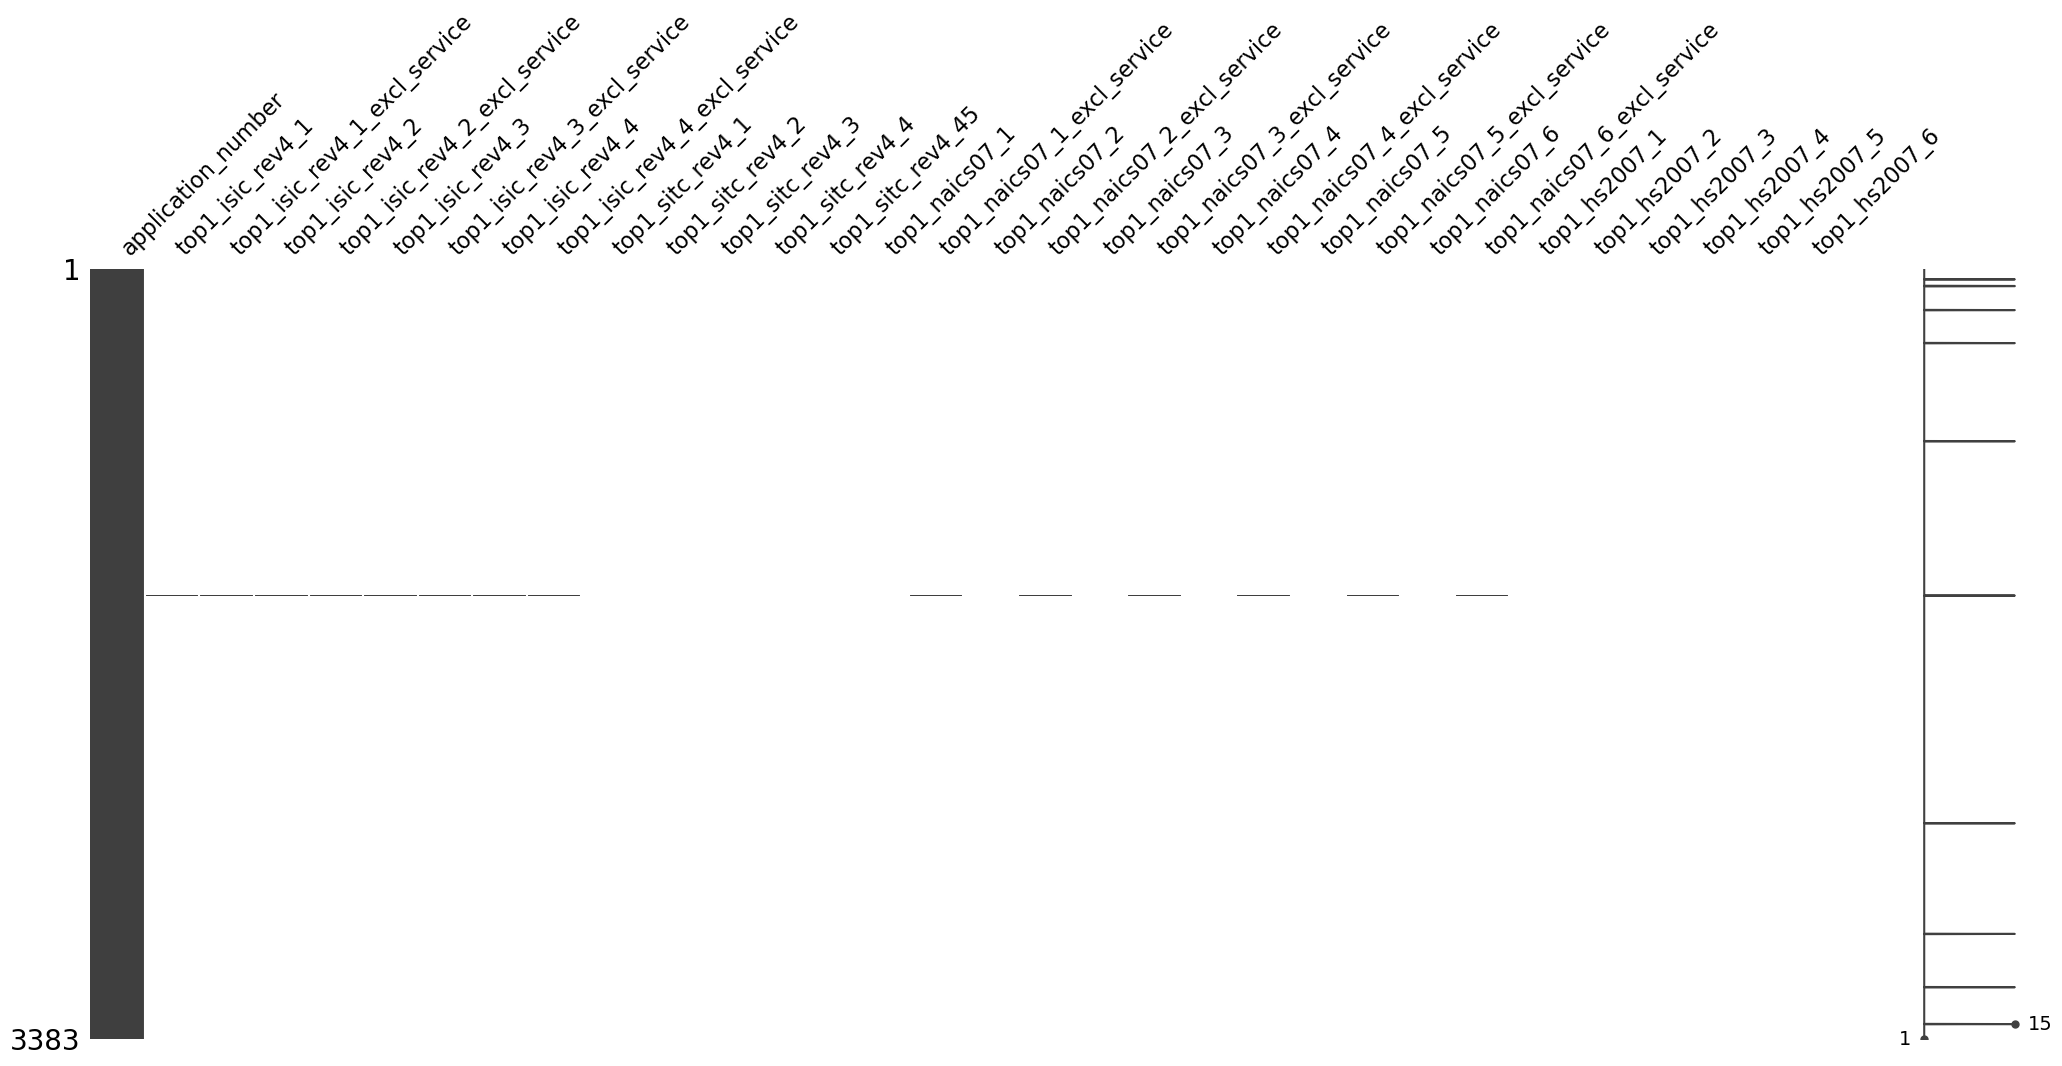

In [20]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Plot missing value matrix
msno.matrix(dropped_first_for_all_df)
plt.show()

All of this data can be safely dropped when loaded, or labeled as unavailable. When it comes to the other data, for each second field there is alot more missing values, but this field is less important so we do not mind having them missing. 

In [21]:
dropped_first_for_all_df =mapped_industry_df.drop(columns=[col for col in mapped_industry_df.columns if col.startswith('top1')]) 
dropped_first_for_all_df = dropped_first_for_all_df[dropped_first_for_all_df.isnull().any(axis=1)]

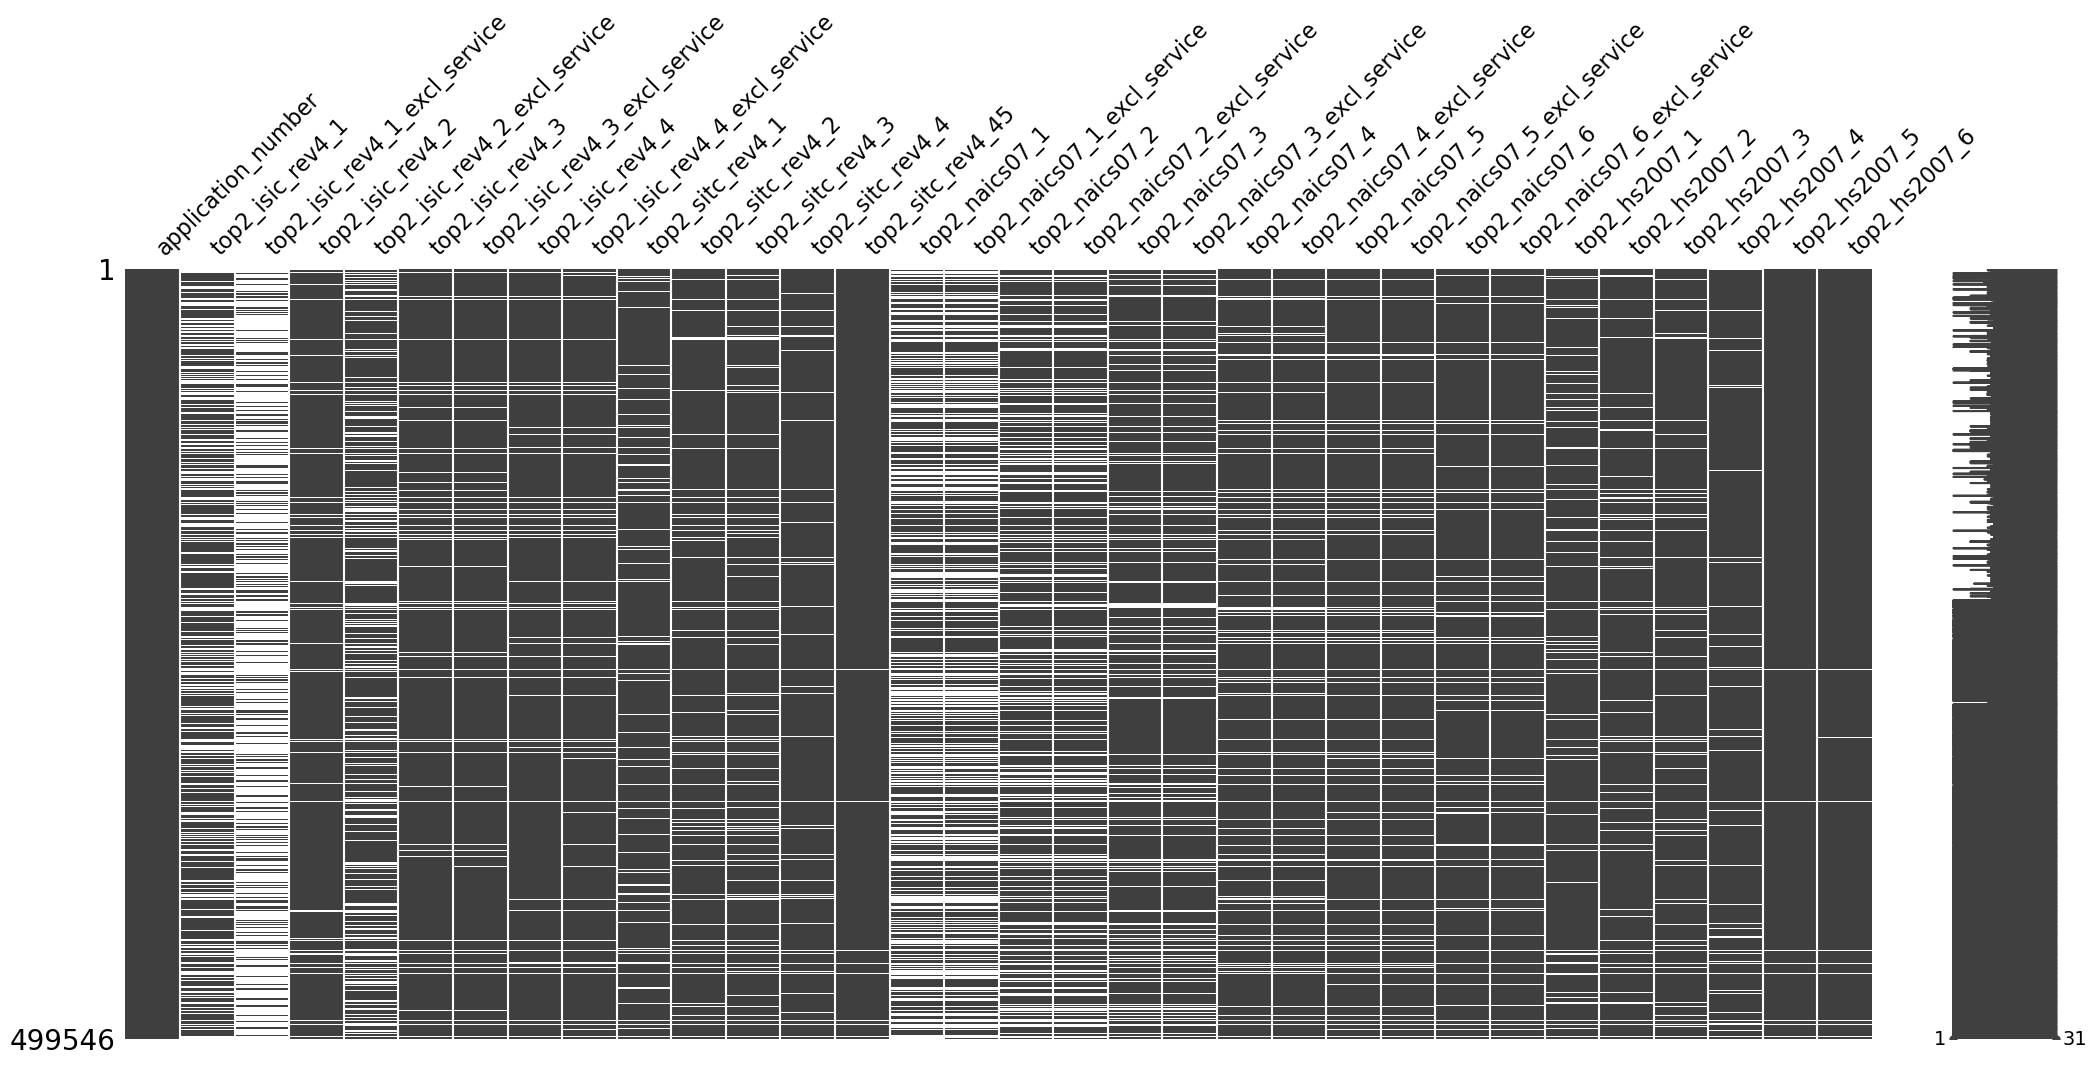

In [22]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Plot missing value matrix
msno.matrix(dropped_first_for_all_df)
plt.show()

In [24]:
mapped_industry_df.to_csv('./Data/full_data_mapped_industries_all_standards_all_levels_top_2.csv',sep='\t',index=False)

# Train test split

In [19]:
cutoff_date='20210101'
publications_cutoff='20230101'


test_df = df_combined[ (df_combined['publication_date']>=cutoff_date) & (df_combined['publication_date']<publications_cutoff)].reset_index(drop=True)
train_df = df_combined[ df_combined['publication_date']<cutoff_date ].reset_index(drop=True)

In [20]:
test_df.to_csv('./Data/test_data_up_to.csv',index=False,sep='\t')

In [21]:
train_df.to_csv('./Data/train_data_up_to.csv', index=False,sep='\t')

We opt for a chronologically based spit. We do this for multilpe reasons one of the main ones being that we want to incorporate historical data to predict the future of a patent and to truly evaluate our model based on such characteristics we must introduce a cutoff for our training set.

The challenge now is how to deal with patents that were granted after the cutoff (and their patent_granted value). The normal approach would be to label such data with a undecided label instead of the regular True/False labels, this is a huge issue since we are going to use the patent_granted column as a label and it would be very easy for our models to predict based on how recent the patent is. If we simply drop these patents we might lose valuable training data for emerging industries, so to avoid this we will simply remove all time related columns (that feature a date). This will make our model predict solely on the characteristics of a patent application rather then adding the recent publications bias that would result from mapping onto a third value or simply mapping to False. Doing this will result to complete ignorance of time of our future models.

## Industry mapping included split

This split was done after applying the idustry based mapping (from the study referenced in the data analisys notbook)

In [23]:
import pandas as pd
full_data_and_industry = pd.read_csv('./Data/up_to_2024_full_patent_data_derived_industry.csv',sep='\t')

cutoff_date=int('20210101')
publications_cutoff=int('20230101')


test_df_industry = full_data_and_industry[ (full_data_and_industry['publication_date']>=cutoff_date) & (full_data_and_industry['publication_date']<publications_cutoff)].reset_index(drop=True)
train_df_industry = full_data_and_industry[ full_data_and_industry['publication_date']<cutoff_date ].reset_index(drop=True)

In [24]:
test_df_industry.to_csv('./Data/test_data_industry.csv',sep='\t',index=False)
train_df_industry.to_csv('./Data/train_data_industry.csv',sep='\t',index=False)

# Parties data aggregation

## Representative data aggregation

### No economic sector data aggregation

Here we want to exract characteristics for each representativ to hopefully enrih our dataset.

In [25]:
# DATA LOADING CELL
import pandas as pd



reps_data_scraped = pd.read_csv('representatives_scraped_and_cleaned',sep='\t')

reps_data_scraped.drop(columns = ['Unnamed: 0','company_identifier','region'],inplace=True)

train_df = pd.read_csv('./Data/train_data_up_to.csv',sep='\t')
test_df = pd.read_csv('./Data/test_data_up_to.csv',sep='\t')

import json

with open('./Data/url_names_dictionary', 'r') as file:
    url_name_dict = json.load(file)

In [8]:
len(url_name_dict)

1286

In [9]:
train_df

,application_number,publication_date,publication_language,rep_name,total_citations,patent_citations,novelty_flag,inventive_step_flag,patent_granted,filing_date,...,search_report_ipc_field,search_report_is_no_unity,search_report_is_incomplete_search,search_report_is_no_search,num_fields,dominant_section,secondary_section,num_in_dominant,num_in_secondary,num_sections
0,14165905.2,20150304,EN,Boult Wade Tennant,15,15,True,False,True,20120305,...,"G01J, G02B, G02C",True,False,False,3,G,G,3,3,1
1,10184069.2,20120704,EN,"Aamand, Jesper L.",13,11,True,False,True,20031030,...,"C12N, C12P, C07B, C40B",True,False,False,4,C,C,4,4,1
2,19162667.0,20200101,EN,"Kordel, Mattias",12,11,True,False,False,20190313,...,"B65F, B29C, G05D",False,False,False,3,B,G,2,1,2
3,12155565.0,20140806,EN,"Greenaway, Martin William",15,15,True,False,False,20120215,...,G06K,False,False,False,1,G,G,1,1,1
4,17205058.5,20180509,EN,"Tostmann, Holger Carl",19,17,True,False,True,20110526,...,C07D,False,False,False,1,C,C,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501777,18206200.0,20190508,EN,NaN,10,10,False,False,False,20161117,...,F02D,False,False,False,1,F,F,1,1,1
501778,14193162.6,20150429,EN,"Barton, Matthew Thomas",11,10,False,False,True,20031202,...,A61B,False,False,False,1,A,A,1,1,1
501779,12198708.5,20140625,EN,"Pons Ariño, Angel",10,10,True,False,True,20121220,...,B60M,False,False,False,1,B,B,1,1,1
501780,12181053.5,20130227,FR,"Ilgart, Jean-Christophe",11,10,False,False,True,20120820,...,H01L,False,False,False,1,H,H,1,1,1


In [26]:
#we want to remove ficpi.org and epo.org since they serve as repositories for patent attorneys

ignore_list = ['https://ficpi.org',
 'https://www.epo.org']


company_attorneys_dict = {'attorney_name':[],'company_url':[]}

for key in url_name_dict.keys():
    if key not in ignore_list:
        company_list = url_name_dict[key]

        for company in company_list:
            company_attorneys_dict['attorney_name'].append(company)
            company_attorneys_dict['company_url'].append(key)

Here we join company and atorneys together since in the dataset a representative can be both an attorney and a company. 

In [27]:
company_attorneys_df = pd.DataFrame(company_attorneys_dict)
reps_data_scraped = pd.concat([reps_data_scraped, company_attorneys_df], ignore_index=True)

We now need to collect summary statistics for each attorney and company from our traininig data. The characteristics we will focus on are the following:
- Dominant section for company/attorney
- Secondary sections for company/attorney
- Number of sections in which attorney has patents
- Number of applications
- Number of patents granted for attorney

THe method we used to scrape the data allows us to look at big conglomarates more clearly, since companies that have subsidiaries in multiple countries are tied to the same domain. After we find all of the statistics for each attrney and company we can group them and sum them up for different domains. This way if a domain occurs with an attorney the expertiese that that company has is not limited by the data we have only for its subsidiary.


In [28]:
df_joined = train_df.merge(
    reps_data_scraped, 
    left_on='rep_name', 
    right_on='attorney_name', 
    how='inner'
)

# Step 2: Define a function that computes the summary characteristics for each representative.
def compute_summary(group):
    # Dominant section: mode of 'dominant_section'
    dom_mode = group['dominant_section'].mode()
    dominant_sec = dom_mode.iloc[0] if not dom_mode.empty else None

    # Secondary section: mode of 'secondary_section'
    sec_mode = group['secondary_section'].mode()
    secondary_sec = sec_mode.iloc[0] if not sec_mode.empty else None

    # Number of sections in which attorney has patents:
    # Take the union of unique values from both 'dominant_section' and 'secondary_section'
    unique_dominant = set(group['dominant_section'].dropna().unique())
    unique_secondary = set(group['secondary_section'].dropna().unique())
    number_of_sections = len(unique_dominant.union(unique_secondary))

    # Number of applications: simply the number of rows for this attorney
    number_of_applications = group.shape[0]

    # Number of patents granted: count where 'patent_granted' is True
    # Assuming 'patent_granted' is a boolean column.
    number_of_patents_granted = group['patent_granted'].sum()

    # Retrieve company_url from the first row (assuming it's the same for all rows for a given attorney)
    company_url = group['company_url'].iloc[0]

    return pd.Series({
        'company_url': company_url,
        'dominant_section_attorney': dominant_sec,
        'secondary_section_attorney': secondary_sec,
        'number_of_sections': number_of_sections,
        'number_of_applications': number_of_applications,
        'number_of_patents_granted': number_of_patents_granted
    })

# Step 3: Group by the attorney name (using the 'attorney_name' column from reps_data_scraped)
summary_df = df_joined.groupby('attorney_name').apply(compute_summary).reset_index()

# Step 4: (Optional) If you want to ensure the new DataFrame has only the columns from reps_data_scraped
# plus the summary columns, you can re-order them as follows:
desired_columns = ['attorney_name', 'company_url', 
                   'dominant_section_attorney', 'secondary_section_attorney', 
                   'number_of_sections', 'number_of_applications', 'number_of_patents_granted']
basic_attorney_summary_characteristics_df = summary_df[desired_columns]


/tmp/ipykernel_11709/1544189512.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = df_joined.groupby('attorney_name').apply(compute_summary).reset_index()


In [29]:
basic_attorney_summary_characteristics_df

,attorney_name,company_url,dominant_section_attorney,secondary_section_attorney,number_of_sections,number_of_applications,number_of_patents_granted
0,"'t Jong, Bastiaan Jacob",https://inaday.eu,E,B,8,180,98
1,2SPL Patentanwälte PartG mbB,https://2spl.de,H,H,6,529,290
2,A.P.I. Conseil,https://www.api-conseil.com,H,G,7,43,21
3,"ABG Intellectual Property Law, S.L.",https://abg-ip.com,C,A,7,147,51
4,ABM Agenzia Brevetti & Marchi,https://abmpat.it,A,A,1,1,0
...,...,...,...,...,...,...,...
2697,Zacco GmbH,https://www.zacco.de,A,A,8,95,51
2698,Zacco Norway AS,https://www.zacco.no,A,A,7,30,17
2699,Zacco Sweden AB,https://www.zacco.com,H,H,8,715,459
2700,advotec.,https://advotec.de,G,B,8,678,472


In [30]:

# ['attorney_name', 'company_url', 'dominant_section_attorney', 'secondary_section_attorney',
#  'number_of_sections', 'number_of_applications', 'number_of_patents_granted']

# Define a helper function to compute the mode safely:
def get_mode(series):
    # Compute the mode of the series; if multiple modes exist, .mode() returns all of them.
    # We'll take the first one if available.
    mode_series = series.mode()
    return mode_series.iloc[0] if not mode_series.empty else None
import pandas as pd

def get_second_most_common(series: pd.Series):
    """
    Return the second most common (second highest frequency) value in the Series.
    If the Series has fewer than 2 unique values or is empty, return None.
    
    Note:
    - This approach simply uses the second entry in `value_counts()`, 
      meaning it doesn't account for "tied" frequencies. 
      If multiple values are tied for the most occurrences, 
      the second item in that tie is considered "second most common."
    """
    if series.empty:
        return None
    
    counts = series.value_counts(dropna=False)
    
    # If there's only 0 or 1 unique value, we can't have a "second most common"
    if len(counts) < 2:
        return counts.index[0]
    
    # The second most common is the second index in value_counts()
    return counts.index[1]


# Group by company_url and aggregate the data as required:
company_summary_df = basic_attorney_summary_characteristics_df.groupby('company_url').agg(
    patent_applications_company=('number_of_applications', 'sum'),
    patents_granted_company=('number_of_patents_granted', 'sum'),
    dominant_company_section=('dominant_section_attorney', get_mode),
    secondary_company_section=('secondary_section_attorney', get_second_most_common)
).reset_index()

In [31]:
company_summary_df

,company_url,patent_applications_company,patents_granted_company,dominant_company_section,secondary_company_section
0,http://abrema.com,162,60,A,B
1,http://agygi.ch,5,3,H,H
2,http://bausch-patent.com,5,2,A,A
3,http://bradl-online.de,7,1,A,A
4,http://cbdl.de,54,42,B,H
...,...,...,...,...,...
965,https://www.zacco.no,34,20,A,A
966,https://www.zbm-patents.eu,157,101,B,F
967,https://www2.esaote.com,23,16,G,G
968,https://xspraypharma.com,1,0,G,G


In the following code we create a dataframe which conains info for each dominant section approvals for each end every attorney. This allows us to create the same but for each company.  

In [32]:
import pandas as pd



# Step 1: Group by attorney, company, and section and compute counts.
# The application count is simply the count of rows for that group.
# The patent count is the sum of patent_granted (since True is 1 and False is 0).
grouped = df_joined.groupby(['attorney_name', 'company_url', 'dominant_section']).agg(
    application_count=('dominant_section', 'count'),
    patent_count=('patent_granted', 'sum')
).reset_index()

# Step 2: Pivot the grouped data so that each section (A-H) becomes a column.
# Pivot for application counts:
applications_pivot = grouped.pivot(
    index=['attorney_name', 'company_url'],
    columns='dominant_section',
    values='application_count'
)
# Pivot for patent counts:
patents_pivot = grouped.pivot(
    index=['attorney_name', 'company_url'],
    columns='dominant_section',
    values='patent_count'
)

# Step 3: Ensure that columns for sections A through H exist and fill missing values with 0.
all_sections = list("ABCDEFGH")
applications_pivot = applications_pivot.reindex(columns=all_sections, fill_value=0)
patents_pivot = patents_pivot.reindex(columns=all_sections, fill_value=0)

# Step 4: Rename the pivot columns to the desired names.
applications_pivot = applications_pivot.rename(columns=lambda sec: f"{sec}_application_count")
patents_pivot = patents_pivot.rename(columns=lambda sec: f"{sec}_patent_count")

# Step 5: Concatenate the two pivot tables along columns.
combined_summary = pd.concat([applications_pivot, patents_pivot], axis=1)

# Step 6: Reset the index to get attorney_name and company_url as columns.
combined_summary = combined_summary.reset_index()

# Step 7: Fill any remaining NaN values with 0 (just in case)
combined_summary = combined_summary.fillna(0)

# (Optional) Step 8: Order the columns so that attorney_name and company_url come first,
# followed by the 8 application_count columns (A-H) and then the 8 patent_count columns (A-H).
app_cols = [f"{sec}_application_count" for sec in all_sections]
patent_cols = [f"{sec}_patent_count" for sec in all_sections]
final_columns = ['attorney_name', 'company_url'] + app_cols + patent_cols
attorney_sections_summary_df = combined_summary[final_columns]


In [33]:
attorney_sections_summary_df.columns

Index(['attorney_name', 'company_url', 'A_application_count',
       'B_application_count', 'C_application_count', 'D_application_count',
       'E_application_count', 'F_application_count', 'G_application_count',
       'H_application_count', 'A_patent_count', 'B_patent_count',
       'C_patent_count', 'D_patent_count', 'E_patent_count', 'F_patent_count',
       'G_patent_count', 'H_patent_count'],
      dtype='object', name='dominant_section')

In [34]:
company_sections_summary_df = attorney_sections_summary_df.drop(columns=['attorney_name']).groupby('company_url').sum().reset_index()
new_column_names = [old_name+'_company' for old_name in list(company_sections_summary_df.columns) if old_name !='company_url']
new_column_names=['company_url'] + new_column_names
company_sections_summary_df.columns = new_column_names

In [35]:
company_sections_summary_df

,company_url,A_application_count_company,B_application_count_company,C_application_count_company,D_application_count_company,E_application_count_company,F_application_count_company,G_application_count_company,H_application_count_company,A_patent_count_company,B_patent_count_company,C_patent_count_company,D_patent_count_company,E_patent_count_company,F_patent_count_company,G_patent_count_company,H_patent_count_company
0,http://abrema.com,50.0,57.0,9.0,2.0,6.0,8.0,11.0,19.0,25.0,21.0,0.0,0.0,5.0,2.0,5.0,2.0
1,http://agygi.ch,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
2,http://bausch-patent.com,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://bradl-online.de,2.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,http://cbdl.de,5.0,21.0,0.0,0.0,2.0,2.0,13.0,11.0,5.0,18.0,0.0,0.0,2.0,1.0,9.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,https://www.zacco.no,18.0,8.0,1.0,0.0,2.0,2.0,2.0,1.0,12.0,6.0,1.0,0.0,1.0,0.0,0.0,0.0
966,https://www.zbm-patents.eu,29.0,20.0,26.0,0.0,8.0,49.0,8.0,17.0,12.0,15.0,6.0,0.0,4.0,46.0,2.0,16.0
967,https://www2.esaote.com,5.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
968,https://xspraypharma.com,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the following section I will be joining up all of the attorney scraped data into one single dataframe and saving it for further use. The company sumarry data will also be joined saved independently.

In [36]:
def join_and_fill_basic_summary_with_defaults(final_df, reps_data_scraped):
    """
    Joins final_df with reps_data_scraped such that:
      - All rows from reps_data_scraped (attorneys) are preserved.
      - If an attorney in reps_data_scraped is missing in final_df, then:
          * All numeric columns are filled with 0.
          * 'dominant_section_attorney' and 'secondary_section_attorney' are set to 'X'.
    
    Parameters:
        final_df (pd.DataFrame): The summary DataFrame containing at least the columns:
                                 'attorney_name', 'company_url',
                                 'dominant_section_attorney', 'secondary_section_attorney',
                                 and some numeric columns (e.g., 'number_of_sections',
                                 'number_of_applications', 'number_of_patents_granted').
        reps_data_scraped (pd.DataFrame): The DataFrame with all attorneys, with at least
                                          'attorney_name' and 'company_url'.
    
    Returns:
        pd.DataFrame: The resulting joined DataFrame.
    """
    # Merge the dataframes using a left join on 'attorney_name'
    merged_df = reps_data_scraped.merge(final_df, on='attorney_name', how='left', suffixes=('', '_final'))
    
    # If the representatives_data_scraped already has a company_url column,
    # you may need to decide which one to keep. For example, if final_df has a different
    # company_url and you prefer reps_data_scraped's version, then do:
    # merged_df['company_url'] = merged_df['company_url']  # from reps_data_scraped.
    # Otherwise, adjust as needed.
    
    # Identify numeric columns in final_df (all those that should be counts)
    # We use the columns from final_df, as these are the ones that will be NaN if missing.
    numeric_cols = final_df.select_dtypes(include='number').columns.tolist()
    
    # Fill missing numeric values with 0
    for col in numeric_cols:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna(0)
    
    # For the two specific string columns, fill NaN with 'X'
    for col in ['dominant_section_attorney', 'secondary_section_attorney']:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna('X')
    
    return merged_df



joined_df = join_and_fill_basic_summary_with_defaults(basic_attorney_summary_characteristics_df, reps_data_scraped)
joined_df.drop(columns=['company_url_final'],inplace=True)

In [37]:
joined_df

,attorney_name,company_url,dominant_section_attorney,secondary_section_attorney,number_of_sections,number_of_applications,number_of_patents_granted
0,"'t Jong, Bastiaan Jacob",https://inaday.eu,E,B,8.0,180.0,98.0
1,"Aagaard, Louise Yung",https://hoiberg.com,X,X,0.0,0.0,0.0
2,"Aalbers, Arnt Reinier",https://dvme.nl,F,B,5.0,8.0,4.0
3,"Aalto, Juha-Matti",https://www.laineip.fi,A,A,2.0,2.0,1.0
4,"Aaltonen, Janne Lari Antero",https://moosedog.fi,A,A,5.0,4.0,2.0
...,...,...,...,...,...,...,...
7037,"Heinonen & Co, Attorneys-at-Law, Ltd",https://www.heinonen.com,X,X,0.0,0.0,0.0
7038,Purschke IP-Büro,http://www.purschke-ip.de,X,X,0.0,0.0,0.0
7039,SAES Getters S.p.A.,https://www.saesgetters.com,X,X,0.0,0.0,0.0
7040,Wolfenbütteler Straße 45,https://www.sqr-law.de,X,X,0.0,0.0,0.0


In [38]:
def join_joined_with_section_summary(result_df, final_summary_df):
    """
    Joins result_df with final_summary_df such that:
      - All rows in result_df (the left side) are preserved.
      - The join is performed on 'attorney_name'.
      - For any attorney not present in final_summary_df, the numeric summary columns
        (application counts and patent counts) are filled with 0.
    
    Parameters:
      result_df (pd.DataFrame): The base DataFrame (e.g. the output from join_and_fill)
                                containing all attorneys.
      final_summary_df (pd.DataFrame): The aggregated summary DataFrame containing columns:
                                       'attorney_name' and various numeric summary columns.
    
    Returns:
      pd.DataFrame: The merged DataFrame.
    """
    # Merge on 'attorney_name' using a left join to preserve all rows from result_df.
    merged_df = pd.merge(result_df, final_summary_df, on='attorney_name', how='left', suffixes=('', '_summary'))
    
    # Identify which columns came from final_summary_df that should be numeric.
    # We assume all columns in final_summary_df except 'attorney_name' are numeric.
    summary_numeric_cols = final_summary_df.drop(columns='attorney_name').select_dtypes(include='number').columns.tolist()
    
    # Fill missing values for these summary columns with 0.
    for col in summary_numeric_cols:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna(0)
    
    return merged_df


final_attorney_data_dataframe = join_joined_with_section_summary(joined_df,attorney_sections_summary_df)

In [39]:
final_attorney_data_dataframe.drop(columns = ['company_url_summary'],inplace=True)

We now want to add the summary section for the company  to the basic company summaries. And finally we ant to join the resulting dataframe with the final_attorney_dataframe. This will produce our train_set attorney data. We will later join this data with our original training data and evaluate how it affects our model performance.


In [40]:

def join_final_attorney_with_company_summary(final_attorney, company_summary_df):
    merged_df = pd.merge(final_attorney, company_summary_df, on='company_url', how='left', suffixes=('', '_summary'))
    
    # Identify which columns came from final_summary_df that should be numeric.
    # We assume all columns in final_summary_df except 'attorney_name' are numeric.
    summary_numeric_cols = company_summary_df.drop(columns='company_url').select_dtypes(include='number').columns.tolist()
    
    # Fill missing values for these summary columns with 0.
    for col in summary_numeric_cols:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna(0)

    for col in ['dominant_company_section', 'secondary_company_section']:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna('X')
    
    return merged_df

merged_attorney_company_summary_df = join_final_attorney_with_company_summary(final_attorney_data_dataframe,company_summary_df)


merged_attorney_company_summary_df

,attorney_name,company_url,dominant_section_attorney,secondary_section_attorney,number_of_sections,number_of_applications,number_of_patents_granted,A_application_count,B_application_count,C_application_count,...,C_patent_count,D_patent_count,E_patent_count,F_patent_count,G_patent_count,H_patent_count,patent_applications_company,patents_granted_company,dominant_company_section,secondary_company_section
0,"'t Jong, Bastiaan Jacob",https://inaday.eu,E,B,8.0,180.0,98.0,37.0,47.0,6.0,...,3.0,0.0,48.0,2.0,5.0,4.0,180.0,98.0,E,B
1,"Aagaard, Louise Yung",https://hoiberg.com,X,X,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,112.0,63.0,A,A
2,"Aalbers, Arnt Reinier",https://dvme.nl,F,B,5.0,8.0,4.0,2.0,0.0,0.0,...,0.0,0.0,1.0,2.0,1.0,0.0,1050.0,618.0,B,H
3,"Aalto, Juha-Matti",https://www.laineip.fi,A,A,2.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,48.0,32.0,A,A
4,"Aaltonen, Janne Lari Antero",https://moosedog.fi,A,A,5.0,4.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,"Heinonen & Co, Attorneys-at-Law, Ltd",https://www.heinonen.com,X,X,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,X
7046,Purschke IP-Büro,http://www.purschke-ip.de,X,X,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,G,H
7047,SAES Getters S.p.A.,https://www.saesgetters.com,X,X,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,X
7048,Wolfenbütteler Straße 45,https://www.sqr-law.de,X,X,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,X


In [41]:
final_merged_train_data_attorney_company_df = join_final_attorney_with_company_summary(merged_attorney_company_summary_df,company_sections_summary_df)

In [42]:
final_merged_train_data_attorney_company_df.columns

Index(['attorney_name', 'company_url', 'dominant_section_attorney',
       'secondary_section_attorney', 'number_of_sections',
       'number_of_applications', 'number_of_patents_granted',
       'A_application_count', 'B_application_count', 'C_application_count',
       'D_application_count', 'E_application_count', 'F_application_count',
       'G_application_count', 'H_application_count', 'A_patent_count',
       'B_patent_count', 'C_patent_count', 'D_patent_count', 'E_patent_count',
       'F_patent_count', 'G_patent_count', 'H_patent_count',
       'patent_applications_company', 'patents_granted_company',
       'dominant_company_section', 'secondary_company_section',
       'A_application_count_company', 'B_application_count_company',
       'C_application_count_company', 'D_application_count_company',
       'E_application_count_company', 'F_application_count_company',
       'G_application_count_company', 'H_application_count_company',
       'A_patent_count_company', 'B_patent_

In [43]:
final_merged_train_data_attorney_company_df.to_csv('./Data/summarry_attorney_company_data_based_on_train_set.csv',sep='\t',index=False)

In [44]:
company_summary_section_summary_merged_df = pd.merge(company_sections_summary_df, company_summary_df, on='company_url')

In [45]:
company_summary_section_summary_merged_df.to_csv('./Data/company_summary_based_on_train_set.csv',sep='\t',index=False)

### Economic Sector data aggregation

NOTE:After mapping the patent classifications to their corresponding industries, the following derived characteristics are given for each attorney:

- Dominant level two sector - Gives the dominant sector at the second level of aggregation for a given attorney.

- Dominant level three sector - Gives the dominant sector at the third level of aggregation for a given attorney.

- Secondary level two sector - The second most common sector at the second level of aggregation for a given attorney.

- Secondary level three sector - Gives the dominant sector at the third level of aggregation for a given attorney.

- Number of  dominant level three sector applications 
- Number of  dominant level two sector  patents 
- Number of  dominant level three sector  patents
- Number of  dominant level two sector applications 

- Number of  secondary level three sector applications 
- Number of  secondary level two sector  patents 
- Number of  secondary level three sector  patents
- Number of  secondary level two sector applications 

- Number of different level two sectors for each attorney
- Number of level three sectors for each attorney


For the companies we need the following characteristics (the companies are the urls themselves, so group by url here):

-Dominant level 2 sector of the company - The sector that has the most applications in it (applications with the same 'company_url').

- Count of dominant level two sector applications: the sum of the applications for each attorney working at the company that has the same dominant sector as the company itself. (can be derived from attorney summary table).

- Mode of the attorneys (meaning the dominant level 2 sector among the attorneys working at the company this can be calculated as the mode from the df we will get for the attorney summary). (named as mode_attorney_company_sector_l2)

- Mode of the secondary sector for each attorney at the company. 

- Mode of the level three sector for each the attorneys at the company. ((named as mode_attorney_company_sector_l3)

-Dominant level 3 sector of the company - The sector that has the most applications in it (applications with the same 'company_url'). named as (dominant_level_3_sector_company)

- Count of dominant level two sector applications: the sum of the applications for each attorney working at the company that has the same dominant.  (count_dominant_l2_applications_company)


In [49]:
# DATA LOADING CELL
import pandas as pd

train_data_industry = pd.read_csv('train_data_industry.csv',sep='\t')
train_data_industry.drop(columns = ['publication_date','Unnamed: 0',
       'publication_language','total_citations',
       'patent_citations', 'novelty_flag', 'inventive_step_flag', 'filing_date', 'patent_granted_date',
       'search_report_date', 'search_report_ipc_field',
       'search_report_is_no_unity', 'search_report_is_incomplete_search',
       'search_report_is_no_search', 'num_fields', 'dominant_section',
       'secondary_section', 'num_in_dominant', 'num_in_secondary','Y_flag',
       'num_sections'],inplace=True)

reps_data_scraped = pd.read_csv('representatives_scraped_and_cleaned',sep='\t')

reps_data_scraped.drop(columns = ['Unnamed: 0','company_identifier','region'],inplace=True)

train_df = pd.read_csv('train_data_up_to.csv',sep='\t')
test_df = pd.read_csv('test_data_up_to.csv',sep='\t')

import json

with open('url_names_dictionary', 'r') as file:
    url_name_dict = json.load(file)

#we want to remove ficpi.org and epo.org since they serve as repositories for patent attorneys

ignore_list = ['https://ficpi.org',
 'https://www.epo.org']


company_attorneys_dict = {'attorney_name':[],'company_url':[]}

for key in url_name_dict.keys():
    if key not in ignore_list:
        company_list = url_name_dict[key]

        for company in company_list:
            company_attorneys_dict['attorney_name'].append(company)
            company_attorneys_dict['company_url'].append(key)


company_attorneys_df = pd.DataFrame(company_attorneys_dict)
reps_data_scraped = pd.concat([reps_data_scraped, company_attorneys_df], ignore_index=True)
    

In [50]:
train_data_industry.columns

Index(['application_number', 'rep_name', 'patent_granted', 'top_l3_industry',
       'top_l2_industry'],
      dtype='object')

In [51]:
df_joined = train_data_industry.merge(
    reps_data_scraped, 
    left_on='rep_name', 
    right_on='attorney_name', 
    how='inner'
)

df_joined["top_l3_industry" ] = df_joined["top_l3_industry"].apply(lambda x: str(int(x)) if not pd.isna(x) else None)


In [52]:
def summarize_attorney(group):
    """
    Summarizes the dominant/secondary L2 and L3 sectors for a given attorney,
    along with the application/patent counts.
    """
    # Value counts for L2 and L3
    l2_counts = group['top_l2_industry'].value_counts()
    l3_counts = group['top_l3_industry'].value_counts()
    
    # Dominant and secondary L2
    dom_l2 = l2_counts.index[0] if len(l2_counts) > 0 else None
    sec_l2 = l2_counts.index[1] if len(l2_counts) > 1 else None
    
    # Dominant and secondary L3
    dom_l3 = l3_counts.index[0] if len(l3_counts) > 0 else None
    sec_l3 = l3_counts.index[1] if len(l3_counts) > 1 else None
    
    # -- Counts for dominant L3 sector (applications & patents)
    num_dom_l3_apps = (group['top_l3_industry'] == dom_l3).sum() if dom_l3 else 0
    num_dom_l3_pats = ((group['top_l3_industry'] == dom_l3) & (group['patent_granted'] == True)).sum() if dom_l3 else 0

    # -- Counts for dominant L2 sector (applications & patents)
    num_dom_l2_apps = (group['top_l2_industry'] == dom_l2).sum() if dom_l2 else 0
    num_dom_l2_pats = ((group['top_l2_industry'] == dom_l2) & (group['patent_granted'] == True)).sum() if dom_l2 else 0
    
    # -- Counts for secondary L3 sector (applications & patents)
    num_sec_l3_apps = (group['top_l3_industry'] == sec_l3).sum() if sec_l3 else 0
    num_sec_l3_pats = ((group['top_l3_industry'] == sec_l3) & (group['patent_granted'] == True)).sum() if sec_l3 else 0
    
    # -- Counts for secondary L2 sector (applications & patents)
    num_sec_l2_apps = (group['top_l2_industry'] == sec_l2).sum() if sec_l2 else 0
    num_sec_l2_pats = ((group['top_l2_industry'] == sec_l2) & (group['patent_granted'] == True)).sum() if sec_l2 else 0
    
    # Number of different L2 sectors
    num_diff_l2 = group['top_l2_industry'].nunique()
    # Number of different L3 sectors
    num_diff_l3 = group['top_l3_industry'].nunique()
    
    return pd.Series({
        'Dominant level two sector': dom_l2,
        'Dominant level three sector': dom_l3,
        'Secondary level two sector': sec_l2,
        'Secondary level three sector': sec_l3,
        
        'Number of dominant level three sector applications': num_dom_l3_apps,
        'Number of dominant level two sector patents': num_dom_l2_pats,
        'Number of dominant level three sector patents': num_dom_l3_pats,
        'Number of dominant level two sector applications': num_dom_l2_apps,
        
        'Number of secondary level three sector applications': num_sec_l3_apps,
        'Number of secondary level two sector patents': num_sec_l2_pats,
        'Number of secondary level three sector patents': num_sec_l3_pats,
        'Number of secondary level two sector applications': num_sec_l2_apps,
        
        'Number of different level two sectors': num_diff_l2,
        'Number of level three sectors': num_diff_l3
    })

# Create the summary dataframe
attorneys_sector_summary = (
    df_joined
    .groupby('attorney_name', as_index=False)
    .apply(summarize_attorney)
)


/tmp/ipykernel_11709/1008849144.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_attorney)


In [53]:
attorneys_sector_summary

,attorney_name,Dominant level two sector,Dominant level three sector,Secondary level two sector,Secondary level three sector,Number of dominant level three sector applications,Number of dominant level two sector patents,Number of dominant level three sector patents,Number of dominant level two sector applications,Number of secondary level three sector applications,Number of secondary level two sector patents,Number of secondary level three sector patents,Number of secondary level two sector applications,Number of different level two sectors,Number of level three sectors
0,"'t Jong, Bastiaan Jacob",C,36,E,23,40,47,29,95,17,41,8,56,7,39
1,2SPL Patentanwälte PartG mbB,Other,59,C,26,165,216,103,377,162,59,89,100,7,26
2,A.P.I. Conseil,C,26,Other,59,16,9,10,19,11,9,4,18,4,14
3,"ABG Intellectual Property Law, S.L.",C,21,B,26,25,31,4,71,22,7,9,24,7,33
4,ABM Agenzia Brevetti & Marchi,B,28,None,None,1,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2697,Zacco GmbH,C,26,Other,36,11,27,4,50,10,4,5,13,6,26
2698,Zacco Norway AS,C,21,B,10,5,7,3,12,5,4,4,5,6,18
2699,Zacco Sweden AB,C,26,Other,27,119,300,61,431,93,81,68,161,7,48
2700,advotec.,C,26,Other,27,123,325,80,448,76,68,54,104,7,49


In [54]:
df_joined.columns

Index(['application_number', 'rep_name', 'patent_granted', 'top_l3_industry',
       'top_l2_industry', 'attorney_name', 'company_url'],
      dtype='object')

In [55]:
attorneys_sector_summary.to_csv('./Data/attorney_economic_sector_summary.csv',sep='\t',index=False)

In [56]:
import pandas as pd

# ---------------------------------------------------
# 1) AGGREGATE BY (company_url, top_l2_industry, top_l3_industry)
#    to find dominant/secondary level 2 & 3 sectors.
# ---------------------------------------------------

df = df_joined.copy()

# Create a helper numeric column for patents
df['patent_granted_num'] = df['patent_granted'].astype(int)

# 1.1) group by company_url, top_l2_industry, top_l3_industry
agg_company = (
    df
    .groupby(['company_url', 'top_l2_industry', 'top_l3_industry'], as_index=False)
    .agg(
        applications=('application_number', 'count'),  # total apps
        patents=('patent_granted_num', 'sum')          # total granted patents
    )
)

# We'll need separate summary DataFrames for L2 and L3, then pick the top (dominant) and second-most (secondary).

# ---------------------------------------------------
# 2) Summaries for Level 2 only
# ---------------------------------------------------
company_l2 = (
    agg_company
    .groupby(['company_url', 'top_l2_industry'], as_index=False)
    .agg(
        l2_applications=('applications', 'sum'),
        l2_patents=('patents', 'sum')
    )
)

def pick_top_two_l2(df_):
    # sort by descending # of L2 applications
    df_ = df_.sort_values('l2_applications', ascending=False)
    top_rows = df_.head(2)
    
    dominant_l2 = top_rows.iloc[0]['top_l2_industry'] if len(top_rows) > 0 else None
    dominant_l2_apps = top_rows.iloc[0]['l2_applications'] if len(top_rows) > 0 else 0
    dominant_l2_pats = top_rows.iloc[0]['l2_patents'] if len(top_rows) > 0 else 0

    secondary_l2 = top_rows.iloc[1]['top_l2_industry'] if len(top_rows) > 1 else None
    secondary_l2_apps = top_rows.iloc[1]['l2_applications'] if len(top_rows) > 1 else 0
    secondary_l2_pats = top_rows.iloc[1]['l2_patents'] if len(top_rows) > 1 else 0

    return pd.Series({
        'dominant_level_2_sector_company': dominant_l2,
        'count_dominant_l2_applications_company': dominant_l2_apps,
        'count_dominant_l2_patents_company': dominant_l2_pats,
        'secondary_level_2_sector_company': secondary_l2,
        'count_secondary_l2_applications_company': secondary_l2_apps,
        'count_secondary_l2_patents_company': secondary_l2_pats,
        'count_different_level_2_sectors_company': df_['top_l2_industry'].nunique()
    })

company_l2_top2 = (
    company_l2
    .groupby('company_url', as_index=False)
    .apply(pick_top_two_l2)
)

# ---------------------------------------------------
# 3) Summaries for Level 3 only
# ---------------------------------------------------
company_l3 = (
    agg_company
    .groupby(['company_url', 'top_l3_industry'], as_index=False)
    .agg(
        l3_applications=('applications', 'sum'),
        l3_patents=('patents', 'sum')
    )
)

def pick_top_two_l3(df_):
    df_ = df_.sort_values('l3_applications', ascending=False)
    top_rows = df_.head(2)

    dominant_l3 = top_rows.iloc[0]['top_l3_industry'] if len(top_rows) > 0 else None
    dominant_l3_apps = top_rows.iloc[0]['l3_applications'] if len(top_rows) > 0 else 0
    dominant_l3_pats = top_rows.iloc[0]['l3_patents'] if len(top_rows) > 0 else 0

    secondary_l3 = top_rows.iloc[1]['top_l3_industry'] if len(top_rows) > 1 else None
    secondary_l3_apps = top_rows.iloc[1]['l3_applications'] if len(top_rows) > 1 else 0
    secondary_l3_pats = top_rows.iloc[1]['l3_patents'] if len(top_rows) > 1 else 0

    return pd.Series({
        'dominant_level_3_sector_company': dominant_l3,
        'count_dominant_l3_applications_company': dominant_l3_apps,
        'count_dominant_l3_patents_company': dominant_l3_pats,
        'secondary_level_3_sector_company': secondary_l3,
        'count_secondary_l3_applications_company': secondary_l3_apps,
        'count_secondary_l3_patents_company': secondary_l3_pats,
        'count_different_level_3_sectors_company': df_['top_l3_industry'].nunique()
    })

company_l3_top2 = (
    company_l3
    .groupby('company_url', as_index=False)
    .apply(pick_top_two_l3)
)

# ---------------------------------------------------
# 4) MERGE L2 AND L3 SUMMARIES
# ---------------------------------------------------
company_base_summary = pd.merge(
    company_l2_top2,
    company_l3_top2,
    on='company_url',
    how='outer'
)

# ---------------------------------------------------
# 5) FIND THE MODE OF ATTORNEYS' SECTORS (dominant L2, secondary L2, dominant L3, etc.)
# ---------------------------------------------------

# Suppose you have the "attorneys_sector_summary" table from previous steps,
# containing attorney_name plus columns:
#   - Dominant level two sector
#   - Secondary level two sector
#   - Dominant level three sector
#   - Secondary level three sector
# etc.
# We want to figure out which attorneys are associated with which companies.
# In df_joined, an attorney_name can appear with multiple company_url's.
# We'll create a mapping of (company_url, attorney_name) pairs.

attorney_company_map = df_joined[['company_url','attorney_name']].drop_duplicates()

# Merge to get each attorney’s summary repeated for each company they appear in.
attorney_company_details = pd.merge(
    attorney_company_map,
    attorneys_sector_summary,  # from your existing attorney-level summary code
    on='attorney_name',
    how='left'
)

# Now we group by company_url to find the mode of the attorneys' dominant/secondary L2, L3, etc.

def get_attorney_modes(df_):
    # For each of the relevant columns, we compute the mode.
    # If no attorneys exist, handle gracefully.
    # We can do a little helper function:
    def mode_of(series):
        counts = series.value_counts(dropna=True)
        return counts.index[0] if len(counts) > 0 else None

    mode_dom_l2 = mode_of(df_['Dominant level two sector'])
    mode_sec_l2 = mode_of(df_['Secondary level two sector'])
    mode_dom_l3 = mode_of(df_['Dominant level three sector'])
    mode_sec_l3 = mode_of(df_['Secondary level three sector'])

    return pd.Series({
        'mode_attorney_company_sector_l2': mode_dom_l2,
        'mode_attorney_company_sector_l2_secondary': mode_sec_l2,
        'mode_attorney_company_sector_l3': mode_dom_l3,
        'mode_attorney_company_sector_l3_secondary': mode_sec_l3
    })

attorney_company_modes = (
    attorney_company_details
    .groupby('company_url', as_index=False)
    .apply(get_attorney_modes)
)

# ---------------------------------------------------
# 6) MERGE EVERYTHING INTO A FINAL company_summary_economic_sectors
# ---------------------------------------------------
company_summary_economic_sectors = pd.merge(
    company_base_summary,
    attorney_company_modes,
    on='company_url',
    how='left'
)

# This final DataFrame will have columns:
#   [
#      company_url,
#      dominant_level_2_sector_company,
#      count_dominant_l2_applications_company,
#      count_dominant_l2_patents_company,
#      secondary_level_2_sector_company,
#      count_secondary_l2_applications_company,
#      count_secondary_l2_patents_company,
#      count_different_level_2_sectors_company,
#      dominant_level_3_sector_company,
#      count_dominant_l3_applications_company,
#      count_dominant_l3_patents_company,
#      secondary_level_3_sector_company,
#      count_secondary_l3_applications_company,
#      count_secondary_l3_patents_company,
#      count_different_level_3_sectors_company,
#      mode_attorney_company_sector_l2,
#      mode_attorney_company_sector_l2_secondary,
#      mode_attorney_company_sector_l3,
#      mode_attorney_company_sector_l3_secondary
#   ]
#
# plus any additional columns you want to bring over.


/tmp/ipykernel_11709/1337459152.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_top_two_l2)
/tmp/ipykernel_11709/1337459152.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_top_two_l3)
/tmp/ipykernel_11709/1337459152.py:166: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

In [57]:
company_summary_economic_sectors.to_csv('./Data/company_summary_economic_sectors.csv',sep = '\t',index=False)


We now want to create ictionaries to create our later datasets for patents, In he se dictionaries we want a (application_count,patent_granted_count) for each attorney and each company. This can be put in the same dictionary, since we identify our companies by url. SO we need a main dictionary with the key in it being the attorney_name/company_name, and then for every key we have a nested dictinary that has keys which are business classifications and the values are tuples of the form (application_count,patent_count).



In [58]:
import pandas as pd

# Example dataframe: df_joined
# Columns: 
#   'application_number', 'rep_name', 'patent_granted', 
#   'top_l3_industry', 'top_l2_industry', 'attorney_name', 'company_url'

# --- 1) Dictionary by attorney_name --- #
# Group by attorney_name and top_l3_industry
grouped_attorneys = (
    df_joined
    .groupby(['attorney_name', 'top_l3_industry'], dropna=False)
    .agg(
        application_count=('application_number', 'nunique'),  # or 'count'
        patent_count=('patent_granted', 'sum')                # assumes patent_granted is 0/1 or boolean
    )
    .reset_index()
)

# Build the dictionary:
# { 
#   'Attorney A': {
#       'Industry X': (application_count, patent_count),
#       'Industry Y': (application_count, patent_count)
#    }, 
#   'Attorney B': { ... },
#   ...
# }
granted_applications_economic_section_dict = {}
for _, row in grouped_attorneys.iterrows():
    attorney = row['attorney_name']
    industry = row['top_l3_industry']
    app_count = row['application_count']
    pat_count = row['patent_count']
    
    if attorney not in granted_applications_economic_section_dict:
        granted_applications_economic_section_dict[attorney] = {}
    granted_applications_economic_section_dict[attorney][industry] = (app_count, pat_count)

# --- 2) Dictionary by company_url --- #
# Group by company_url and top_l3_industry
grouped_companies = (
    df_joined
    .groupby(['company_url', 'top_l3_industry'], dropna=False)
    .agg(
        application_count=('application_number', 'nunique'),  # or 'count'
        patent_count=('patent_granted', 'sum')                # assumes patent_granted is 0/1 or boolean
    )
    .reset_index()
)

# Build the dictionary:
# {
#   'https://company1.com': {
#       'Industry A': (application_count, patent_count),
#       'Industry B': (application_count, patent_count)
#    },
#   'https://company2.com': { ... },
#   ...
# }
for _, row in grouped_companies.iterrows():
    company = row['company_url']
    industry = row['top_l3_industry']
    app_count = row['application_count']
    pat_count = row['patent_count']
    
    if company not in granted_applications_economic_section_dict:
        granted_applications_economic_section_dict[company] = {}
    granted_applications_economic_section_dict[company][industry] = (app_count, pat_count)


grouped_attorneys_l2 = (
    df_joined
    .groupby(['attorney_name', 'top_l2_industry'], dropna=False)
    .agg(
        application_count=('application_number', 'nunique'),  # or 'count'
        patent_count=('patent_granted', 'sum')                # if patent_granted is 0/1 or boolean
    )
    .reset_index()
)

for _, row in grouped_attorneys_l2.iterrows():
    attorney = row['attorney_name']
    industry_l2 = row['top_l2_industry']
    app_count = row['application_count']
    pat_count = row['patent_count']
    
    if attorney not in granted_applications_economic_section_dict:
        granted_applications_economic_section_dict[attorney] = {}
    granted_applications_economic_section_dict[attorney][industry_l2] = (app_count, pat_count)

# --- 2) Dictionary by company_url, grouped by top_l2_industry --- #
grouped_companies_l2 = (
    df_joined
    .groupby(['company_url', 'top_l2_industry'], dropna=False)
    .agg(
        application_count=('application_number', 'nunique'),  # or 'count'
        patent_count=('patent_granted', 'sum')                # if patent_granted is 0/1 or boolean
    )
    .reset_index()
)

for _, row in grouped_companies_l2.iterrows():
    company = row['company_url']
    industry_l2 = row['top_l2_industry']
    app_count = row['application_count']
    pat_count = row['patent_count']
    
    if company not in granted_applications_economic_section_dict:
        granted_applications_economic_section_dict[company] = {}
    granted_applications_economic_section_dict[company][industry_l2] = (app_count, pat_count)

In [61]:
import json

# Save dictionary as a JSON file
def save_dict_to_json(dictionary, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(dictionary, f, ensure_ascii=False, indent=4)

In [62]:
save_dict_to_json(granted_applications_economic_section_dict,'./Data/granted_applications_economic_section_dict.json')

# Regression data

In [1]:
import pandas as pd

In [2]:
basic_patent_data = pd.read_csv('./Data/basic_patent_data_PATSTAT_IMPUTED_TARGET.csv',sep='\t')

In [3]:
basic_patent_data.columns

Index(['application_number', 'filing_date', 'ipc_field', 'is_no_unity',
       'is_incomplete_search', 'is_no_search', 'applicant_names',
       'applicant_countries', 'inventor_names', 'inventor_countries',
       'representative_name', 'representative_country', 'patent_granted_date',
       'patent_granted', 'publication_types', 'publication_date',
       'publication_number', 'status', 'status_text', 'value_imputed',
       'application_status_target'],
      dtype='object')

In [1]:
import pandas as pd
train_data = pd.read_csv('./Data/train_data_industry.csv',sep='\t')
test_data = pd.read_csv('./Data/test_data_industry.csv',sep='\t')

In [2]:
to_keep=['search_report_date','patent_granted_date','application_number','patent_granted','rep_name','Y_flag', 'total_citations',
 'patent_citations','novelty_flag','search_report_is_no_unity','top_l3_industry','top_l2_industry']
to_remove = [c  for c in train_data.columns if c not in to_keep] 
 

In [3]:
to_remove

['Unnamed: 0',
 'publication_date',
 'publication_language',
 'inventive_step_flag',
 'filing_date',
 'search_report_ipc_field',
 'search_report_is_incomplete_search',
 'search_report_is_no_search',
 'num_fields',
 'dominant_section',
 'secondary_section',
 'num_in_dominant',
 'num_in_secondary',
 'num_sections']

In [4]:
regression_data = train_data.drop(columns = to_remove)
regression_data = regression_data[regression_data['patent_granted']==True]
regression_test_data = test_data.drop(columns = to_remove)
regression_test_data = regression_test_data[regression_test_data['patent_granted']==True]

In [5]:
import numpy as np
# 1. Convert patent_granted_date and search_report_date to datetime
regression_data['patent_granted_date'] = pd.to_datetime(regression_data['patent_granted_date'], format='%Y%m%d')
regression_data['search_report_date'] = pd.to_datetime(regression_data['search_report_date'], format='%Y%m%d')

# 2. Create a timedelta by subtracting dates
time_diff = regression_data['patent_granted_date'] - regression_data['search_report_date']

# 3. Calculate difference in days
regression_data['days_to_grant'] = time_diff.dt.days  # integer

# 4. Calculate difference in months (float)
#    Option A: Approximate months by dividing days by ~30.44
regression_data['months_to_grant'] = regression_data['days_to_grant'] / 30.44
regression_data.reset_index(drop=True, inplace=True)



In [6]:
regression_test_data['patent_granted_date'] = pd.to_datetime(regression_test_data['patent_granted_date'], format='%Y%m%d')
regression_test_data['search_report_date'] = pd.to_datetime(regression_test_data['search_report_date'], format='%Y%m%d')

# 2. Create a timedelta by subtracting dates
time_diff = regression_test_data['patent_granted_date'] - regression_test_data['search_report_date']

# 3. Calculate difference in days
regression_test_data['days_to_grant'] = time_diff.dt.days  # integer

# 4. Calculate difference in months (float)
#    Option A: Approximate months by dividing days by ~30.44
regression_test_data['months_to_grant'] = regression_test_data['days_to_grant'] / 30.44
regression_test_data.reset_index(drop=True, inplace=True)


We now want to join thi s data together with the company, attorney and industry data and derive the following characteristcs.

1. Average time to grant for company/attorney
2. Average time to grant for each industry (as an industry average)
3. NUmber of granted patents for company/attorney as a ratio and a log of number of applications for attorney/company
4. Ratio of patent_citations/number_citations and log(number_citations)
5. The flags from the original dataframe.

In [7]:
attorney_company_data = pd.read_csv('./Data/summarry_attorney_company_data_based_on_train_set.csv',sep='\t')

In [8]:
attorney_company_data.columns

Index(['attorney_name', 'company_url', 'dominant_section_attorney',
       'secondary_section_attorney', 'number_of_sections',
       'number_of_applications', 'number_of_patents_granted',
       'A_application_count', 'B_application_count', 'C_application_count',
       'D_application_count', 'E_application_count', 'F_application_count',
       'G_application_count', 'H_application_count', 'A_patent_count',
       'B_patent_count', 'C_patent_count', 'D_patent_count', 'E_patent_count',
       'F_patent_count', 'G_patent_count', 'H_patent_count',
       'patent_applications_company', 'patents_granted_company',
       'dominant_company_section', 'secondary_company_section',
       'A_application_count_company', 'B_application_count_company',
       'C_application_count_company', 'D_application_count_company',
       'E_application_count_company', 'F_application_count_company',
       'G_application_count_company', 'H_application_count_company',
       'A_patent_count_company', 'B_patent_

In [9]:
to_keep=['attorney_name', 'company_url', 

'number_of_applications', 'number_of_patents_granted',

'patent_applications_company', 'patents_granted_company'
]
to_remove = [c  for c in attorney_company_data.columns if c not in to_keep] 

In [10]:
attorney_company_data.drop(columns = to_remove,inplace=True)

In [11]:
regression_data = pd.merge(regression_data, attorney_company_data, left_on='rep_name',right_on='attorney_name', how='inner')  # 'inner' keeps only matching IDs
regression_test_data = pd.merge(regression_test_data, attorney_company_data, left_on='rep_name',right_on='attorney_name', how='inner')  # 'inner' keeps only matching IDs

In [12]:
import pandas as pd
import numpy as np


# --- A) Company Average (Train) ---
avg_days_grant_by_company = (
    regression_data.groupby('company_url')['days_to_grant']
            .mean()
            .to_dict()  # store as a dictionary for easy mapping
)

# --- B) Attorney Average (Train) ---
avg_days_grant_by_attorney = (
    regression_data.groupby('attorney_name')['days_to_grant']
            .mean()
            .to_dict()
)

# --- C) Industry L2 Average (Train) ---
avg_days_grant_by_l2 = (
    regression_data.groupby('top_l2_industry')['days_to_grant']
            .mean()
            .to_dict()
)

# --- D) Industry L3 Average (Train) ---
avg_days_grant_by_l3 = (
    regression_data.groupby('top_l3_industry')['days_to_grant']
            .mean()
            .to_dict()
)


# Compute ratio by summing or averaging in train:
granted_by_company = regression_data.groupby('company_url')['patents_granted_company'].sum()
apps_by_company    = regression_data.groupby('company_url')['patent_applications_company'].sum()
ratio_by_company   = (granted_by_company / apps_by_company).to_dict()




In [13]:
import numpy as np
import pandas as pd


global_avg_days_grant = regression_data['days_to_grant'].mean()  # optional fallback



# -------------------------
# 1) Average time to grant (days_to_grant) for each company and attorney
#    We'll use groupby + transform to get per-group averages back in the original shape.
# -------------------------
regression_data['avg_days_to_grant_company'] = (
    regression_data.groupby('company_url')['days_to_grant']
      .transform('mean')
)

regression_data['avg_days_to_grant_attorney'] = (
    regression_data.groupby('attorney_name')['days_to_grant']
      .transform('mean')
)

# -------------------------
# 2) Average time to grant for each industry (both L2 and L3)
# -------------------------
regression_data['avg_days_to_grant_l2'] = (
    regression_data.groupby('top_l2_industry')['days_to_grant']
      .transform('mean')
)

regression_data['avg_days_to_grant_l3'] = (
    regression_data.groupby('top_l3_industry')['days_to_grant']
      .transform('mean')
)

regression_data['avg_days_to_grant_l2'].fillna(global_avg_days_grant)

regression_data['avg_days_to_grant_l3'].fillna(global_avg_days_grant)
# -------------------------
# 3) Number of granted patents as a ratio, and log of number of applications
#    We assume you want the ratio for both attorney and company, as well as separate logs.
# -------------------------
# Ratio (company) = patents_granted_company / patent_applications_company
regression_data['ratio_granted_company'] = (
    regression_data['patents_granted_company'] / regression_data['patent_applications_company']
)

# Ratio (attorney) = number_of_patents_granted / number_of_applications
regression_data['ratio_granted_attorney'] = (
    regression_data['number_of_patents_granted'] / regression_data['number_of_applications']
)

# Now take the log of number of applications. We add 1 to avoid log(0).
regression_data['log_company_applications'] = np.log(regression_data['patent_applications_company'] + 1)
regression_data['log_attorney_applications'] = np.log(regression_data['number_of_applications'] + 1)

# -------------------------
# 4) Ratio patent_citations/total_citations and log(total_citations)
#    Again, add 1 if total_citations might be 0.
# -------------------------
regression_data['citations_ratio'] = regression_data['patent_citations'] / regression_data['total_citations']
regression_data['log_total_citations'] = np.log(regression_data['total_citations'] + 1)
# -------------------------
# -------------------------

In [14]:
global_avg_days_grant = regression_data['days_to_grant'].mean()  # optional fallback

mean_ratio_by_attorney = (
    regression_data.groupby('attorney_name')['ratio_granted_attorney'].mean()
)

regression_data['log_attorney_applications'] = np.log(regression_data['patent_applications_company'] + 1)

log_comp_applications_by_company = (
    regression_data.groupby('company_url')['log_company_applications']
            .mean()
)

regression_data['log_company_applications'] = np.log(regression_data['patent_applications_company'] + 1)

log_comp_applications_by_company = (
    regression_data.groupby('company_url')['log_company_applications']
            .mean()
)
log_comp_applications_dict = log_comp_applications_by_company.to_dict()

# Fallback for unknown companies in test
global_log_company_apps = log_comp_applications_by_company.mean()

log_atty_applications_by_attorney = (
    regression_data.groupby('attorney_name')['log_attorney_applications'].mean()
)


log_atty_applications_dict = log_atty_applications_by_attorney.to_dict()
global_log_attorney_apps = log_atty_applications_by_attorney.mean()

# OR Option 2: Sum-based ratio
# granted_by_attorney = df_train.groupby('attorney_name')['number_of_patents_granted'].sum()
# apps_by_attorney    = df_train.groupby('attorney_name')['number_of_applications'].sum()
# ratio_by_attorney   = (granted_by_attorney / apps_by_attorney)

# Convert to dictionary for mapping
ratio_by_attorney_dict = mean_ratio_by_attorney.to_dict()

# A fallback (in case an attorney_name in test doesn't appear in train)
global_attorney_ratio = mean_ratio_by_attorney.mean()

regression_test_data['log_company_applications'] = regression_test_data['company_url'].map(log_comp_applications_dict)
regression_test_data['log_company_applications'].fillna(global_log_company_apps, inplace=True)



# --- A) Company ---
regression_test_data['avg_days_to_grant_company'] = regression_test_data['company_url'].map(avg_days_grant_by_company)
regression_test_data['avg_days_to_grant_company'] = regression_test_data['avg_days_to_grant_company'].fillna(global_avg_days_grant)

# --- B) Attorney ---
regression_test_data['avg_days_to_grant_attorney'] = regression_test_data['attorney_name'].map(avg_days_grant_by_attorney)
regression_test_data['avg_days_to_grant_attorney'] = regression_test_data['avg_days_to_grant_attorney'].fillna(global_avg_days_grant)

# --- C) L2 Industry ---
regression_test_data['avg_days_to_grant_l2'] = regression_test_data['top_l2_industry'].map(avg_days_grant_by_l2)
regression_test_data['avg_days_to_grant_l2'] = regression_test_data['avg_days_to_grant_l2'].fillna(global_avg_days_grant)

# --- D) L3 Industry ---
regression_test_data['avg_days_to_grant_l3'] = regression_test_data['top_l3_industry'].map(avg_days_grant_by_l3)
regression_test_data['avg_days_to_grant_l3'] = regression_test_data['avg_days_to_grant_l3'].fillna(global_avg_days_grant)

# Map to test
regression_test_data['ratio_granted_company'] = regression_test_data['company_url'].map(ratio_by_company)

# fallback or fill:
regression_test_data['ratio_granted_company'] = regression_test_data['ratio_granted_company'].fillna(ratio_by_company.get('global', 0))

# Create the feature using the train-derived dictionary
regression_test_data['ratio_granted_attorney'] = regression_test_data['attorney_name'].map(ratio_by_attorney_dict)

regression_test_data['citations_ratio'] = regression_test_data['patent_citations'] / regression_test_data['total_citations']
regression_test_data['log_total_citations'] = np.log(regression_test_data['total_citations'] + 1)


regression_test_data['log_attorney_applications'] = regression_test_data['attorney_name'].map(log_atty_applications_dict)
regression_test_data['log_attorney_applications'].fillna(global_log_attorney_apps, inplace=True)

# Fill missing attorneys with global mean (or 0, or another choice)
regression_test_data['ratio_granted_attorney'].fillna(global_attorney_ratio, inplace=True)

/tmp/ipykernel_3251/937232629.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  regression_test_data['log_company_applications'].fillna(global_log_company_apps, inplace=True)
/tmp/ipykernel_3251/937232629.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

In [15]:
cols_to_drop = [
    'patents_granted_company',
    'patent_applications_company',
    'number_of_patents_granted',
    'number_of_applications',
    'patent_citations',
    'total_citations','rep_name', 'total_citations', 'patent_citations',
    'patent_granted', 'patent_granted_date', 
    'attorney_name',
    'patent_applications_company', 'patents_granted_company',
]
regression_data.drop(columns=cols_to_drop, inplace=True)
regression_test_data.drop(columns=cols_to_drop, inplace=True)

In [16]:
regression_test_data.columns

Index(['application_number', 'novelty_flag', 'Y_flag', 'search_report_date',
       'search_report_is_no_unity', 'top_l3_industry', 'top_l2_industry',
       'days_to_grant', 'months_to_grant', 'company_url',
       'log_company_applications', 'avg_days_to_grant_company',
       'avg_days_to_grant_attorney', 'avg_days_to_grant_l2',
       'avg_days_to_grant_l3', 'ratio_granted_company',
       'ratio_granted_attorney', 'citations_ratio', 'log_total_citations',
       'log_attorney_applications'],
      dtype='object')

In [17]:
regression_test_data.to_csv('./Data/regression_test_data.csv',sep='\t',index=False)
regression_data.to_csv('./Data/regression_train_data.csv',sep='\t',index=False)

In [25]:
regression_test_data

,application_number,novelty_flag,Y_flag,search_report_date,search_report_is_no_unity,top_l3_industry,top_l2_industry,days_to_grant,months_to_grant,company_url,log_company_applications,avg_days_to_grant_company,avg_days_to_grant_attorney,avg_days_to_grant_l2,avg_days_to_grant_l3,ratio_granted_company,ratio_granted_attorney,citations_ratio,log_total_citations,log_attorney_applications
0,20197407.8,True,False,2021-02-17,False,26.0,C,1071,35.183968,http://www.praxi-ip.praxi,6.246107,1236.355721,1312.071429,1123.087312,1192.522666,0.737864,0.666667,1.0,2.484907,6.246107
1,20194418.8,True,True,2020-12-21,False,27.0,C,1409,46.287779,https://www.studiotorta.com,7.795235,1074.467773,924.633333,1123.087312,1120.528642,0.800659,0.937500,1.0,2.890372,7.795235
2,22170334.1,False,False,2022-11-16,False,21.0,B,203,6.668857,https://www.keltie.com,5.996452,1127.462555,1135.987890,1107.833573,1164.483247,0.546135,0.618015,1.0,2.484907,5.287962
3,20163308.8,True,True,2020-12-10,True,30.0,Other,1140,37.450723,https://www.gesthuysen-patentanwaelte.de,5.517453,1307.515982,1925.250000,1179.546364,1059.987739,0.834677,1.000000,1.0,2.484907,5.517453
4,21186318.8,True,True,2021-12-02,False,23.0,C,496,16.294350,https://www.corradini.it,5.379897,944.212903,946.758170,1123.087312,1089.032002,0.680556,0.683962,1.0,2.564949,5.379897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21989,22155442.1,False,False,2022-06-06,False,28.0,C,751,24.671485,https://www.eisenfuhr.com,7.573531,1146.615599,1140.451705,1123.087312,1083.928293,0.705398,0.704225,1.0,2.397895,7.573531
21990,21171869.7,True,False,2021-10-22,False,32.0,C,635,20.860710,https://germainmaureau.com,6.107023,1060.177049,1135.987890,1123.087312,1094.376159,0.658482,0.618015,1.0,2.397895,5.287962
21991,21173608.7,True,False,2021-09-01,False,1.0,A,721,23.685940,https://www.biplegal.com,6.327937,1081.714286,1081.714286,1180.923628,1161.036772,0.279070,0.279070,1.0,2.397895,6.327937
21992,20192735.7,True,False,2020-10-19,False,24.0,C,1395,45.827858,https://www.meissnerbolte.com,6.989335,1205.319149,1333.610390,1123.087312,1115.728587,0.617159,0.633929,1.0,2.397895,6.989335


# Clusterring data

In [1]:
import pandas as pd

full_data= pd.read_csv('train_data_industry.csv',sep='\t')

In [9]:
sampled_patents.columns

Index(['Unnamed: 0', 'application_number', 'publication_date',
       'publication_language', 'rep_name', 'total_citations',
       'patent_citations', 'novelty_flag', 'inventive_step_flag',
       'patent_granted', 'filing_date', 'patent_granted_date', 'Y_flag',
       'search_report_date', 'search_report_ipc_field',
       'search_report_is_no_unity', 'search_report_is_incomplete_search',
       'search_report_is_no_search', 'num_fields', 'dominant_section',
       'secondary_section', 'num_in_dominant', 'num_in_secondary',
       'num_sections', 'top_l3_industry', 'top_l2_industry'],
      dtype='object')

In [2]:
import pandas as pd

# Filter only the granted patents
granted_patents = full_data[full_data['patent_granted'] == True]

# Randomly sample 1000 patents (adjust if fewer than 1000 exist)
sampled_patents = granted_patents.sample(n=1000, random_state=42)  # Set seed for reproducib

In [6]:
my_application_numbers = list(sampled_patents['application_number'])

# Convert the list of application numbers into a comma-separated string of quoted values:
numbers_str = ", ".join(f"'{num}'" for num in my_application_numbers)

# Define your field selection. We want the application number and the abstract text:
selection = (
    "a.application.number AS application_number, "
    "a.abstract AS abstract_text"
)

# Define the condition so we only select rows whose application.number is in our list:
condition = f"WHERE a.application.number IN ({numbers_str}) AND a.abstract IS NOT NULL AND a.abstract.language='EN'"

# Build the query statement:
statement = (
    f"SELECT {selection} "
    f"FROM `{epab.full_table_name}` AS a "
    f"{condition}"
)

# Print or log the statement for debugging:
print(statement)

# Finally, execute the query:
results = epab.sql_query(statement)

# 'results' will contain rows with 'application_number' and 'abstract_text' columns.



SELECT a.application.number AS application_number, a.abstract AS abstract_text FROM `p-epo-tip-prj-3a1f.p_epo_tip_euwe4_bqd_epab.publications` AS a WHERE a.application.number IN ('16192564.9', '16155786.3', '20150578.1', '16161363.3', '17157293.6', '17189667.3', '11172892.9', '13186613.9', '18195311.8', '12182581.4', '17154296.2', '17163279.7', '15151581.4', '13172574.9', '15158510.6', '18169883.8', '12153570.2', '12182148.2', '19158555.3', '17157078.1', '14176924.0', '15201547.5', '16168366.9', '12172428.0', '18199667.9', '16190664.9', '16173345.6', '16181697.0', '12181756.3', '18198096.2', '14200140.3', '19180736.1', '13180806.5', '13306230.7', '19180007.7', '18180318.0', '14156861.8', '16200327.1', '16198774.8', '15159272.2', '14185823.3', '16201126.6', '7108719.1', '15166831.6', '13179377.0', '17185147.0', '14195501.3', '15191056.9', '12163872.0', '14003235.0', '19174559.5', '16166453.7', '17202534.8', '19213122.5', '13189084.0', '12175170.5', '15151377.7', '12460035.4', '19186688.

In [7]:
import pandas as pd
from bs4 import BeautifulSoup

# Suppose `results` is a list of dicts like:
# [
#   {
#     'application_number': '16182125.1',
#     'abstract_text': {'language': 'EN', 'text': '<p>Some markup...</p>'}
#   },
#   ...
# ]

# Build a list of rows, where each row is a dict with the needed columns.
rows = []
for record in results:
    application_num = record['application_number']
    
    # Some records might have an 'abstract_text' that is None or missing.
    # So let's handle that safely:
    if record.get('abstract_text') and record['abstract_text'].get('text'):
        raw_abstract = record['abstract_text']['text']
        
        # Parse and remove tags using BeautifulSoup:
        soup = BeautifulSoup(raw_abstract, 'html.parser')
        parsed_text = soup.get_text()
    
    rows.append({
        'application_number': application_num,
        'parsed_abstract': parsed_text
    })

# Create a DataFrame from the list of rows
df = pd.DataFrame(rows)




In [11]:
sampled_patents['application_number'] = sampled_patents['application_number'].map(lambda x: str(x)
)

In [12]:
to_save = pd.merge(sampled_patents,df,on='application_number',how='inner')

In [15]:
to_save.to_csv('./Data/clustering_dataset.csv',sep='\t',index=False)